# Notebook comparison stats

## Setup

## Functions

In [ ]:
"""
Notebook-style script to compute SELMA3D segmentation metrics
for 3 models (autumn, expert, random) across 4 data types and 3 CV folds.

Metrics per patch:
- total_dice      : average of foreground and background Dice
- foreground_dice : Dice on foreground voxels only (union of pred/GT foreground)
- instances_pred  : # of connected components in prediction
- instances_gt    : # of connected components in GT
- Betti numbers   : b0, b1, b2 (for pred and GT), optional (requires gudhi)

Final summary table:
- Averages of each score over all prediction files for each
  (model, data_type). In your setup, this corresponds to averaging
  over the 2 results per CV fold * 3 folds = 6 results total.
"""

# ==========================
# Cell 1 – Imports & Config
# ==========================

import os
from pathlib import Path
import re
import warnings

import nibabel as nib
import numpy as np
import pandas as pd

from scipy.ndimage import label as cc_label

# Optional: Betti numbers via Gudhi (cubical complex)
# If this import fails, Betti numbers will be disabled unless you
# install gudhi (e.g., `pip install gudhi`).
try:
    import gudhi
    HAS_GUDHI = True
except ImportError:
    HAS_GUDHI = False
    warnings.warn(
        "Gudhi not installed. Betti numbers will be disabled unless you install gudhi."
    )

# -------------------
# PATH CONFIGURATION
# -------------------

# prediction roots (already point at the .../preds folders)
MODEL_ROOTS = {
    "autumn": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds"),
    "expert": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds"),
    "random": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds"),
}

# ground-truth root
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")

# datatype <-> GT folder mapping
DATA_TYPES = ["amyloid_plaque", "c_fos_positive", "cell_nucleus", "vessels"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

# define output directory
OUTPUT_DIR = Path("/midtier/paetzollab/scratch/ads4015/segmentation_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# threshold on probability map to get binary prediction
PROB_THRESHOLD = 0.5

# connectivity structure for 3D connected components (26-connectivity)
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)

# whether to compute Betti numbers (requires gudhi)
ENABLE_BETTI = HAS_GUDHI
ENABLE_BETTI = False ## UP TO HERE
print(f"Gudhi installed: {HAS_GUDHI}, ENABLE_BETTI = {ENABLE_BETTI}")


# =======================================
# Cell 2 – Utility: NIfTI Loader & Parsing
# =======================================

def load_nifti(path: Path) -> np.ndarray:
    """Load a NIfTI file and return a float32 numpy array."""
    img = nib.load(str(path))
    arr = img.get_fdata(dtype=np.float32)
    return arr


# Regex for prediction filename pattern:
# example: patch_003_vol016_ch0_prob_cvfold2_ntr12_nev2_fttr10_ftval2_fold2_trlim12_seed100.nii.gz
PRED_NAME_RE = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_prob_.*\.nii\.gz$")


def parse_pred_name(pred_path: Path):
    """Parse patch_id, vol_id, channel_id from a prediction filename."""
    m = PRED_NAME_RE.match(pred_path.name)
    if m is None:
        raise ValueError(f"Cannot parse prediction filename: {pred_path}")
    patch_id, vol_id, ch_id = m.groups()
    return patch_id, vol_id, ch_id


def build_gt_path(data_type: str, patch_id: str, vol_id: str, ch_id: str) -> Path:
    """Build the ground-truth label path from metadata."""
    gt_subdir = DATA_TYPE_TO_GT_SUBDIR[data_type]
    gt_folder = GT_ROOT / gt_subdir
    gt_name = f"patch_{patch_id}_vol{vol_id}_ch{ch_id}_label.nii.gz"
    return gt_folder / gt_name


# ======================================
# Cell 3 – Dice Metrics (Total & Foreground)
# ======================================

def binary_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Standard foreground Dice on full volume."""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection + eps) / (pred.sum() + gt.sum() + eps)


def background_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Dice between background regions."""
    pred_bg = np.logical_not(pred)
    gt_bg = np.logical_not(gt)
    intersection = np.logical_and(pred_bg, gt_bg).sum()
    return (2.0 * intersection + eps) / (pred_bg.sum() + gt_bg.sum() + eps)


def total_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """'Total Dice' = average of foreground and background Dice scores."""
    fg_d = binary_dice(pred_bin, gt_bin, eps=eps)
    bg_d = background_dice(pred_bin, gt_bin, eps=eps)
    return 0.5 * (fg_d + bg_d)


def foreground_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """Foreground Dice computed only on voxels that are foreground in either pred or GT.

    This uses the union of pred/GT foreground voxels as the evaluation region.
    If the union is empty (both masks all-background), returns 1.0 by convention.
    """
    pred_bin = pred_bin.astype(bool)
    gt_bin = gt_bin.astype(bool)
    fg_union = np.logical_or(pred_bin, gt_bin)
    if fg_union.sum() == 0:
        return 1.0

    pred_f = pred_bin[fg_union]
    gt_f = gt_bin[fg_union]
    intersection = np.logical_and(pred_f, gt_f).sum()
    return (2.0 * intersection + eps) / (pred_f.sum() + gt_f.sum() + eps)


# ========================================
# Cell 4 – Instance Counts (Connected Components)
# ========================================

def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    """Count connected components (instances) in a 3D binary mask."""
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    labeled, n_components = cc_label(mask, structure=structure)
    return int(n_components)


# ================================
# Cell 5 – Betti Numbers (Optional)
# ================================

def compute_betti(mask: np.ndarray):
    """Compute Betti numbers (b0, b1, b2) of a 3D binary mask via Gudhi.

    Returns a dict with keys 'betti_0', 'betti_1', 'betti_2'.
    If ENABLE_BETTI is False, returns NaNs for these values.
    """
    if not ENABLE_BETTI:
        return {"betti_0": np.nan, "betti_1": np.nan, "betti_2": np.nan}

    data = mask.astype(np.float32)
    cc = gudhi.CubicalComplex(dimensions=data.shape, top_dimensional_cells=data.flatten())
    bettis = cc.betti_numbers()  # list [b0, b1, b2, ...]

    b = [0, 0, 0]
    for i in range(min(len(bettis), 3)):
        b[i] = bettis[i]

    return {"betti_0": b[0], "betti_1": b[1], "betti_2": b[2]}


# =========================================
# Cell 6 – Per-patch Metric Computation
# =========================================

def compute_metrics_for_pair(pred_path: Path, gt_path: Path) -> dict:
    """Compute all metrics for a single prediction/GT pair.

    Returns a flat dict of metric_name -> value.
    """
    pred_prob = load_nifti(pred_path)
    gt_bin = load_nifti(gt_path)

    # binarize
    pred_bin = pred_prob >= PROB_THRESHOLD
    gt_bin = gt_bin > 0.5  # GT should already be 0/1, but this is safe

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(
            f"Shape mismatch: pred {pred_bin.shape}, gt {gt_bin.shape} for {pred_path} vs {gt_path}"
        )

    # Dice metrics
    td = total_dice(pred_bin, gt_bin)
    fd = foreground_dice(pred_bin, gt_bin)

    # Instance counts
    n_inst_pred = count_instances(pred_bin)
    n_inst_gt = count_instances(gt_bin)

    # Instance Dice based on counts (scalar Dice on instance numbers)
    if n_inst_pred == 0 and n_inst_gt == 0:
        inst_dice = 1.0
    else:
        inst_dice = (2.0 * min(n_inst_pred, n_inst_gt)) / float(n_inst_pred + n_inst_gt)

    # Betti numbers (for predictions and GT separately)
    betti_pred = compute_betti(pred_bin)
    betti_gt = compute_betti(gt_bin)

    metrics = {
        "total_dice": td,
        "foreground_dice": fd,
        "instance_dice": inst_dice,
        "instances_pred": n_inst_pred,
        "instances_gt": n_inst_gt,
    }

    # Prefix Betti keys
    for k, v in betti_pred.items():
        metrics[f"pred_{k}"] = v
    for k, v in betti_gt.items():
        metrics[f"gt_{k}"] = v

    return metrics


# ==================================================
# Cell 7 – Discovery & Loop Over All Models / Types
# ==================================================

def discover_pred_files(model_root: Path, data_type: str):
    """Discover all prediction files for a given model root and data_type.

    Returns a list of (pred_path, cvfold_name).
    """
    results = []
    type_root = model_root / data_type
    if not type_root.is_dir():
        warnings.warn(f"{type_root} does not exist; skipping.")
        return results

    # cvfold directories like: cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100
    for fold_dir in sorted(type_root.iterdir()):
        if not fold_dir.is_dir():
            continue
        if not fold_dir.name.startswith("cvfold"):
            continue

        cvfold_name = fold_dir.name  # keep full string
        preds_dir = fold_dir / "preds"
        if not preds_dir.is_dir():
            warnings.warn(f"No preds/ directory in {fold_dir}; skipping.")
            continue

        for pred_path in sorted(preds_dir.glob("*_prob_*.nii.gz")):
            # Only use raw probability maps; skip thresholded *_pred_* files
            results.append((pred_path, cvfold_name))

    return results


def collect_all_metrics():
    """Iterate over models, data types, CV folds, and compute per-file metrics.

    Returns a pandas DataFrame with one row per prediction file.
    """
    rows = []

    for model_name, model_root in MODEL_ROOTS.items():
        print(f"\n[INFO] Processing model: {model_name} ({model_root})")

        for data_type in DATA_TYPES:
            print(f"  - data_type: {data_type}")
            pred_items = discover_pred_files(model_root, data_type)

            for pred_path, cvfold_name in pred_items:
                try:
                    patch_id, vol_id, ch_id = parse_pred_name(pred_path)
                except ValueError as e:
                    warnings.warn(str(e))
                    continue

                gt_path = build_gt_path(data_type, patch_id, vol_id, ch_id)

                if not gt_path.is_file():
                    warnings.warn(f"GT not found for {pred_path}: {gt_path}")
                    continue

                try:
                    metrics = compute_metrics_for_pair(pred_path, gt_path)
                except Exception as e:
                    warnings.warn(f"Failed metrics for {pred_path} vs {gt_path}: {e}")
                    continue

                row = {
                    "model": model_name,
                    "data_type": data_type,
                    "cvfold": cvfold_name,   # e.g. cvfold0_ntr3_...
                    "cvfold_id": cvfold_name.split("_")[0],  # e.g. 'cvfold0'
                    "patch_id": patch_id,
                    "vol_id": vol_id,
                    "channel_id": ch_id,
                    "pred_path": str(pred_path),
                    "gt_path": str(gt_path),
                }
                row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    return df


# Run the collection to get the full per-file metrics table.
metrics_df = collect_all_metrics()
print("\n[INFO] Done. Number of rows:", len(metrics_df))

# Peek at the first few rows
display(metrics_df.head())


# =======================================
# Cell 9b – Extract train size from cvfold
# =======================================

# We want to compare performance as a function of train size (ntr),
# so we extract ntr from the cvfold folder name and store it in the
# per-file metrics table.

def extract_train_size(cvfold_name: str, model_name: str):
    """Extract the x-axis train size from a cvfold string.

    For the pretrained models (autumn/expert/random), we use the true ntr value
    encoded as `_ntr<k>_`.

    For microSAM, the folder naming is:
        fold_cvX_poolP_ntrK_nvalM_ntestN
    where `pool` is really the train size (ntr) and `ntr` corresponds to fttr.

    So for microsam we take `pool` as the x-axis value; for the others we take `ntr`.
    """
    if model_name == "microsam":
        m_pool = re.search(r"_pool(\d+)_", cvfold_name)
        if m_pool:
            return int(m_pool.group(1))

    m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
    if m_ntr:
        return int(m_ntr.group(1))

    return np.nan


metrics_df["train_size"] = metrics_df.apply(
    lambda row: extract_train_size(row["cvfold"], row["model"]),
    axis=1,
)


print("[INFO] Unique train sizes found:", sorted(metrics_df["train_size"].dropna().unique()))
display(metrics_df.head())


# ==========================================================
# Cell 10b – Fold-level summary (per train size / cvfold)
# ==========================================================

# Metrics to aggregate
metric_columns = [
    "total_dice",
    "foreground_dice",
    "instance_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

# We average over files *within* a cvfold directory (e.g., 2 prob
# outputs per fold), but keep each cvfold/train_size separate.
summary_by_model_type_fold = (
    metrics_df
    .groupby(["model", "data_type", "cvfold", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size", "cvfold"])
)

print("[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):")
display(summary_by_model_type_fold.head())

summary_fold_csv_path = OUTPUT_DIR / "summary_by_model_type_and_fold_train_size.csv"
summary_by_model_type_fold.to_csv(summary_fold_csv_path, index=False)
print("Fold-level summary saved to:", summary_fold_csv_path)


# ==========================================================
# Cell 10c – Train-size summary (averaged over folds)
# ==========================================================

# For each (model, data_type, train_size), average metrics over all
# folds that share the same train_size. This is what we will use for
# the tables and plots.
summary_by_model_type_train = (
    summary_by_model_type_fold
    .groupby(["model", "data_type", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size"])
)

train_summary_csv_path = OUTPUT_DIR / "summary_by_model_type_and_train_size.csv"
summary_by_model_type_train.to_csv(train_summary_csv_path, index=False)
print("Train-size-averaged summary saved to:", train_summary_csv_path)




# ======================================
# Cell 8 – Save Raw Metrics to CSV
# ======================================

raw_csv_path = OUTPUT_DIR / "selma3d_segmentation_metrics_per_file.csv"
metrics_df.to_csv(raw_csv_path, index=False)
print("Raw per-file metrics saved to:", raw_csv_path)


# ==========================================================
# Cell 9 – Summary: Averages over files (2 per fold × 3 folds)
# ==========================================================

# For each (model, data_type), we now average each metric over all
# prediction files. Given your setup (2 files per CV fold, 3 folds),
# this corresponds to averaging over exactly 6 results per combination.

metric_columns = [
    "total_dice",
    "foreground_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

summary_by_model_type = (
    metrics_df
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

print("\n[INFO] Summary: Averages of each score over all files (2×3 = 6 per pair)")
display(summary_by_model_type)

summary_csv_path = OUTPUT_DIR / "summary_by_model_and_type_means.csv"
summary_by_model_type.to_csv(summary_csv_path, index=False)
print("Summary (by model & type) saved to:", summary_csv_path)


# ==========================================================
# Cell 10 – (Optional) Summary with fold-level means
# ==========================================================

# If you ever want to see how consistent the folds are, you can first
# average within each (model, data_type, cvfold_id) and then average
# across cvfold_id.

fold_means = (
    metrics_df
    .groupby(["model", "data_type", "cvfold_id"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage = (
    fold_means
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

# This two-stage mean should be identical to summary_by_model_type as
# long as each fold has the same number of files (which is true in your
# current setup with exactly 2 results per fold).

summary_two_stage_csv = OUTPUT_DIR / "summary_by_model_and_type_two_stage_means.csv"
summary_two_stage.to_csv(summary_two_stage_csv, index=False)
print("Two-stage fold-then-model means saved to:", summary_two_stage_csv)


# ================================
# Cell 11 – Plot summary table inline
# ================================
import matplotlib.pyplot as plt

# ================================
# Cell 11b – Plot summary vs train size
# ================================

# Choose which metrics to visualize in plots
PLOT_METRICS = ["total_dice", "foreground_dice", "instance_dice"]


# 1) Pretty table view for each data_type

def show_summary_table_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Sort rows by train size then model so it's easy to read
    df_dt = df_dt.sort_values(["train_size", "model"])

    # Betti columns (if present)
    betti_cols = [
        c
        for c in [
            "pred_betti_0",
            "pred_betti_1",
            "pred_betti_2",
            "gt_betti_0",
            "gt_betti_1",
            "gt_betti_2",
        ]
        if c in df_dt.columns
    ]

    cols = ["model", "train_size"] + PLOT_METRICS + betti_cols
    cols = [c for c in cols if c in df_dt.columns]

    # Keep as a regular DataFrame to avoid Styler issues with
    # non-unique indices; we don't set a MultiIndex here.
    table = df_dt[cols]

    num_format_cols = [c for c in PLOT_METRICS + betti_cols if c in table.columns]

    styled = (
        table.style
        .format("{:.4f}", subset=num_format_cols)
        .set_caption(f"Train-size-averaged summary for data type: {data_type}")
        .background_gradient(axis=None)
    )
    display(styled)


# 2) Line plots: metric vs train_size, one line per model

def plot_metric_vs_train_size_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Ensure sorted order of train sizes
    df_dt = df_dt.sort_values(["train_size", "model"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in summary table; skipping.")
            continue

        plt.figure(figsize=(6, 4))

        for model, df_m in df_dt.groupby("model"):
            plt.plot(
                df_m["train_size"],
                df_m[metric],
                marker="o",
                label=model,
            )

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}")
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()


# ================================
# Cell 11c – Plot all fold points + best‑fit lines vs train size
# ================================

import numpy as np

# We now plot ALL fold‑level points (summary_by_model_type_fold)
# and fit a linear regression line for each model.


def plot_scatter_and_regression_for_type(data_type: str):
    # Use per-file metrics (metrics_df), not the fold-averaged summary
    df_dt = metrics_df[metrics_df["data_type"] == data_type].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Drop rows where train_size is missing
    df_dt = df_dt.dropna(subset=["train_size"])

    # Sort mainly for nicer lines
    df_dt = df_dt.sort_values(["train_size", "model", "cvfold", "patch_id"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in metrics_df; skipping.")
            continue

        df_metric = df_dt.dropna(subset=[metric])
        if df_metric.empty:
            print(f"[WARN] No non-NaN values for metric '{metric}' in {data_type}; skipping.")
            continue

        plt.figure(figsize=(7, 5))

        # Plot all *file-level* points per model
        for model, df_m in df_metric.groupby("model"):
            plt.scatter(
                df_m["train_size"],
                df_m[metric],
                label=f"{model} (files)",
                alpha=0.6,
            )

            # Fit a best-fit line across all file-level points
            x = df_m["train_size"].astype(float).to_numpy()
            y = df_m[metric].astype(float).to_numpy()
            # need at least 2 distinct train_sizes for a line
            if len(np.unique(x)) > 1:
                coef = np.polyfit(x, y, 1)  # linear fit
                poly = np.poly1d(coef)
                xs = np.linspace(min(x), max(x), 100)
                plt.plot(xs, poly(xs), label=f"{model} fit")

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(
            f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}\n"
            f"(All file-level points + best-fit lines)"
        )
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


# Run tables (train-size‑averaged) + scatter+lines
for dt in DATA_TYPES:
    print(f"==============================")
    print(f"Data type: {dt}")
    print("==============================")
    show_summary_table_for_type(dt)  # table still shows fold‑averaged
    plot_scatter_and_regression_for_type(dt)


In [ ]:
"""
Notebook-style script to compute SELMA3D segmentation metrics
for 3 models (autumn, expert, random) across 4 data types and 3 CV folds.

Metrics per patch:
- total_dice      : average of foreground and background Dice
- foreground_dice : Dice on foreground voxels only (union of pred/GT foreground)
- instances_pred  : # of connected components in prediction
- instances_gt    : # of connected components in GT
- Betti numbers   : b0, b1, b2 (for pred and GT), optional (requires gudhi)

Final summary table:
- Averages of each score over all prediction files for each
  (model, data_type). In your setup, this corresponds to averaging
  over the 2 results per CV fold * 3 folds = 6 results total.
"""

# ==========================
# Cell 1 – Imports & Config
# ==========================

import os
from pathlib import Path
import re
import warnings

import nibabel as nib
import numpy as np
import pandas as pd

from scipy.ndimage import label as cc_label

# Optional: Betti numbers via Gudhi (cubical complex)
# If this import fails, Betti numbers will be disabled unless you
# install gudhi (e.g., `pip install gudhi`).
try:
    import gudhi
    HAS_GUDHI = True
except ImportError:
    HAS_GUDHI = False
    warnings.warn(
        "Gudhi not installed. Betti numbers will be disabled unless you install gudhi."
    )

# -------------------
# PATH CONFIGURATION
# -------------------

# prediction roots (already point at the .../preds folders)
MODEL_ROOTS = {
    "autumn": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds"),
    "expert": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds"),
    "random": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds"),
}

# ground-truth root
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")

# datatype <-> GT folder mapping
DATA_TYPES = ["amyloid_plaque", "c_fos_positive", "cell_nucleus", "vessels"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

# define output directory
OUTPUT_DIR = Path("/midtier/paetzollab/scratch/ads4015/segmentation_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# threshold on probability map to get binary prediction
PROB_THRESHOLD = 0.5

# connectivity structure for 3D connected components (26-connectivity)
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)

# whether to compute Betti numbers (requires gudhi)
ENABLE_BETTI = HAS_GUDHI
print(f"Gudhi installed: {HAS_GUDHI}, ENABLE_BETTI = {ENABLE_BETTI}")


# =======================================
# Cell 2 – Utility: NIfTI Loader & Parsing
# =======================================

def load_nifti(path: Path) -> np.ndarray:
    """Load a NIfTI file and return a float32 numpy array."""
    img = nib.load(str(path))
    arr = img.get_fdata(dtype=np.float32)
    return arr


# Regex for prediction filename pattern:
# example: patch_003_vol016_ch0_prob_cvfold2_ntr12_nev2_fttr10_ftval2_fold2_trlim12_seed100.nii.gz
PRED_NAME_RE = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_prob_.*\.nii\.gz$")


def parse_pred_name(pred_path: Path):
    """Parse patch_id, vol_id, channel_id from a prediction filename."""
    m = PRED_NAME_RE.match(pred_path.name)
    if m is None:
        raise ValueError(f"Cannot parse prediction filename: {pred_path}")
    patch_id, vol_id, ch_id = m.groups()
    return patch_id, vol_id, ch_id


def build_gt_path(data_type: str, patch_id: str, vol_id: str, ch_id: str) -> Path:
    """Build the ground-truth label path from metadata."""
    gt_subdir = DATA_TYPE_TO_GT_SUBDIR[data_type]
    gt_folder = GT_ROOT / gt_subdir
    gt_name = f"patch_{patch_id}_vol{vol_id}_ch{ch_id}_label.nii.gz"
    return gt_folder / gt_name


# ======================================
# Cell 3 – Dice Metrics (Total & Foreground)
# ======================================

def binary_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Standard foreground Dice on full volume."""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection + eps) / (pred.sum() + gt.sum() + eps)


def background_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Dice between background regions."""
    pred_bg = np.logical_not(pred)
    gt_bg = np.logical_not(gt)
    intersection = np.logical_and(pred_bg, gt_bg).sum()
    return (2.0 * intersection + eps) / (pred_bg.sum() + gt_bg.sum() + eps)


def total_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """'Total Dice' = average of foreground and background Dice scores."""
    fg_d = binary_dice(pred_bin, gt_bin, eps=eps)
    bg_d = background_dice(pred_bin, gt_bin, eps=eps)
    return 0.5 * (fg_d + bg_d)


def foreground_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """Foreground Dice computed only on voxels that are foreground in either pred or GT.

    This uses the union of pred/GT foreground voxels as the evaluation region.
    If the union is empty (both masks all-background), returns 1.0 by convention.
    """
    pred_bin = pred_bin.astype(bool)
    gt_bin = gt_bin.astype(bool)
    fg_union = np.logical_or(pred_bin, gt_bin)
    if fg_union.sum() == 0:
        return 1.0

    pred_f = pred_bin[fg_union]
    gt_f = gt_bin[fg_union]
    intersection = np.logical_and(pred_f, gt_f).sum()
    return (2.0 * intersection + eps) / (pred_f.sum() + gt_f.sum() + eps)


# ========================================
# Cell 4 – Instance Counts (Connected Components)
# ========================================

def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    """Count connected components (instances) in a 3D binary mask."""
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    labeled, n_components = cc_label(mask, structure=structure)
    return int(n_components)


# ================================
# Cell 5 – Betti Numbers (Optional)
# ================================

def compute_betti(mask: np.ndarray):
    """Compute Betti numbers (b0, b1, b2) of a 3D binary mask via Gudhi.

    Returns a dict with keys 'betti_0', 'betti_1', 'betti_2'.
    If ENABLE_BETTI is False, returns NaNs for these values.
    """
    if not ENABLE_BETTI:
        return {"betti_0": np.nan, "betti_1": np.nan, "betti_2": np.nan}

    data = mask.astype(np.float32)

    try:
        cc = gudhi.CubicalComplex(
            dimensions=data.shape,
            top_dimensional_cells=data.flatten(),
        )
        # MUST compute persistence before calling betti_numbers()
        cc.compute_persistence()
        bettis = cc.betti_numbers()  # list [b0, b1, b2, ...]
    except Exception as e:
        warnings.warn(f"Betti computation failed: {e}; returning NaNs")
        return {"betti_0": np.nan, "betti_1": np.nan, "betti_2": np.nan}

    b = [0, 0, 0]
    for i in range(min(len(bettis), 3)):
        b[i] = bettis[i]

    return {"betti_0": b[0], "betti_1": b[1], "betti_2": b[2]}



# =========================================
# Cell 6 – Per-patch Metric Computation
# =========================================

def compute_metrics_for_pair(pred_path: Path, gt_path: Path) -> dict:
    """Compute all metrics for a single prediction/GT pair.

    Returns a flat dict of metric_name -> value.
    """
    pred_prob = load_nifti(pred_path)
    gt_bin = load_nifti(gt_path)

    # binarize
    pred_bin = pred_prob >= PROB_THRESHOLD
    gt_bin = gt_bin > 0.5  # GT should already be 0/1, but this is safe

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(
            f"Shape mismatch: pred {pred_bin.shape}, gt {gt_bin.shape} for {pred_path} vs {gt_path}"
        )

    # Dice metrics
    td = total_dice(pred_bin, gt_bin)
    fd = foreground_dice(pred_bin, gt_bin)

    # Instance counts
    n_inst_pred = count_instances(pred_bin)
    n_inst_gt = count_instances(gt_bin)

    # Instance Dice based on counts (scalar Dice on instance numbers)
    if n_inst_pred == 0 and n_inst_gt == 0:
        inst_dice = 1.0
    else:
        inst_dice = (2.0 * min(n_inst_pred, n_inst_gt)) / float(n_inst_pred + n_inst_gt)

    # Betti numbers (for predictions and GT separately)
    betti_pred = compute_betti(pred_bin)
    betti_gt = compute_betti(gt_bin)

    metrics = {
        "total_dice": td,
        "foreground_dice": fd,
        "instance_dice": inst_dice,
        "instances_pred": n_inst_pred,
        "instances_gt": n_inst_gt,
    }

    # Prefix Betti keys
    for k, v in betti_pred.items():
        metrics[f"pred_{k}"] = v
    for k, v in betti_gt.items():
        metrics[f"gt_{k}"] = v

    return metrics


# ==================================================
# Cell 7 – Discovery & Loop Over All Models / Types
# ==================================================

def discover_pred_files(model_root: Path, data_type: str):
    """Discover all prediction files for a given model root and data_type.

    Returns a list of (pred_path, cvfold_name).
    """
    results = []
    type_root = model_root / data_type
    if not type_root.is_dir():
        warnings.warn(f"{type_root} does not exist; skipping.")
        return results

    # cvfold directories like: cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100
    for fold_dir in sorted(type_root.iterdir()):
        if not fold_dir.is_dir():
            continue
        if not fold_dir.name.startswith("cvfold"):
            continue

        cvfold_name = fold_dir.name  # keep full string
        preds_dir = fold_dir / "preds"
        if not preds_dir.is_dir():
            warnings.warn(f"No preds/ directory in {fold_dir}; skipping.")
            continue

        for pred_path in sorted(preds_dir.glob("*_prob_*.nii.gz")):
            # Only use raw probability maps; skip thresholded *_pred_* files
            results.append((pred_path, cvfold_name))

    return results


def collect_all_metrics():
    """Iterate over models, data types, CV folds, and compute per-file metrics.

    Returns a pandas DataFrame with one row per prediction file.
    """
    rows = []

    for model_name, model_root in MODEL_ROOTS.items():
        print(f"\n[INFO] Processing model: {model_name} ({model_root})")

        for data_type in DATA_TYPES:
            print(f"  - data_type: {data_type}")
            pred_items = discover_pred_files(model_root, data_type)

            for pred_path, cvfold_name in pred_items:
                try:
                    patch_id, vol_id, ch_id = parse_pred_name(pred_path)
                except ValueError as e:
                    warnings.warn(str(e))
                    continue

                gt_path = build_gt_path(data_type, patch_id, vol_id, ch_id)

                if not gt_path.is_file():
                    warnings.warn(f"GT not found for {pred_path}: {gt_path}")
                    continue

                try:
                    metrics = compute_metrics_for_pair(pred_path, gt_path)
                except Exception as e:
                    warnings.warn(f"Failed metrics for {pred_path} vs {gt_path}: {e}")
                    continue

                row = {
                    "model": model_name,
                    "data_type": data_type,
                    "cvfold": cvfold_name,   # e.g. cvfold0_ntr3_...
                    "cvfold_id": cvfold_name.split("_")[0],  # e.g. 'cvfold0'
                    "patch_id": patch_id,
                    "vol_id": vol_id,
                    "channel_id": ch_id,
                    "pred_path": str(pred_path),
                    "gt_path": str(gt_path),
                }
                row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    return df


# Run the collection to get the full per-file metrics table.
metrics_df = collect_all_metrics()
print("\n[INFO] Done. Number of rows:", len(metrics_df))

# Peek at the first few rows
display(metrics_df.head())


# =======================================
# Cell 9b – Extract train size from cvfold
# =======================================

# We want to compare performance as a function of train size (ntr),
# so we extract ntr from the cvfold folder name and store it in the
# per-file metrics table.

def extract_train_size(cvfold_name: str):
    """Extract train size (ntr) from a cvfold string.

    Example:
        'cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100' -> 3
    """
    m = re.search(r"_ntr(\d+)_", cvfold_name)
    if m:
        return int(m.group(1))
    return np.nan


metrics_df["train_size"] = metrics_df["cvfold"].apply(extract_train_size)

print("[INFO] Unique train sizes found:", sorted(metrics_df["train_size"].dropna().unique()))
display(metrics_df.head())


# ==========================================================
# Cell 10b – Fold-level summary (per train size / cvfold)
# ==========================================================

# Metrics to aggregate
metric_columns = [
    "total_dice",
    "foreground_dice",
    "instance_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

# We average over files *within* a cvfold directory (e.g., 2 prob
# outputs per fold), but keep each cvfold/train_size separate.
summary_by_model_type_fold = (
    metrics_df
    .groupby(["model", "data_type", "cvfold", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size", "cvfold"])
)

print("[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):")
display(summary_by_model_type_fold.head())

summary_fold_csv_path = OUTPUT_DIR / "summary_by_model_type_and_fold_train_size.csv"
summary_by_model_type_fold.to_csv(summary_fold_csv_path, index=False)
print("Fold-level summary saved to:", summary_fold_csv_path)


# ==========================================================
# Cell 10c – Train-size summary (averaged over folds)
# ==========================================================

# For each (model, data_type, train_size), average metrics over all
# folds that share the same train_size. This is what we will use for
# the tables and plots.
summary_by_model_type_train = (
    summary_by_model_type_fold
    .groupby(["model", "data_type", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size"])
)

train_summary_csv_path = OUTPUT_DIR / "summary_by_model_type_and_train_size.csv"
summary_by_model_type_train.to_csv(train_summary_csv_path, index=False)
print("Train-size-averaged summary saved to:", train_summary_csv_path)




# ======================================
# Cell 8 – Save Raw Metrics to CSV
# ======================================

raw_csv_path = OUTPUT_DIR / "selma3d_segmentation_metrics_per_file.csv"
metrics_df.to_csv(raw_csv_path, index=False)
print("Raw per-file metrics saved to:", raw_csv_path)


# ==========================================================
# Cell 9 – Summary: Averages over files (2 per fold × 3 folds)
# ==========================================================

# For each (model, data_type), we now average each metric over all
# prediction files. Given your setup (2 files per CV fold, 3 folds),
# this corresponds to averaging over exactly 6 results per combination.

metric_columns = [
    "total_dice",
    "foreground_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

summary_by_model_type = (
    metrics_df
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

print("\n[INFO] Summary: Averages of each score over all files (2×3 = 6 per pair)")
display(summary_by_model_type)

summary_csv_path = OUTPUT_DIR / "summary_by_model_and_type_means.csv"
summary_by_model_type.to_csv(summary_csv_path, index=False)
print("Summary (by model & type) saved to:", summary_csv_path)


# ==========================================================
# Cell 10 – (Optional) Summary with fold-level means
# ==========================================================

# If you ever want to see how consistent the folds are, you can first
# average within each (model, data_type, cvfold_id) and then average
# across cvfold_id.

fold_means = (
    metrics_df
    .groupby(["model", "data_type", "cvfold_id"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage = (
    fold_means
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

# This two-stage mean should be identical to summary_by_model_type as
# long as each fold has the same number of files (which is true in your
# current setup with exactly 2 results per fold).

summary_two_stage_csv = OUTPUT_DIR / "summary_by_model_and_type_two_stage_means.csv"
summary_two_stage.to_csv(summary_two_stage_csv, index=False)
print("Two-stage fold-then-model means saved to:", summary_two_stage_csv)


# ================================
# Cell 11 – Plot summary table inline
# ================================
import matplotlib.pyplot as plt

# ================================
# Cell 11b – Plot summary vs train size
# ================================

# Choose which metrics to visualize in plots
PLOT_METRICS = ["total_dice", "foreground_dice", "instance_dice"]


# 1) Pretty table view for each data_type

def show_summary_table_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Sort rows by train size then model so it's easy to read
    df_dt = df_dt.sort_values(["train_size", "model"])

    # Betti columns (if present)
    betti_cols = [
        c
        for c in [
            "pred_betti_0",
            "pred_betti_1",
            "pred_betti_2",
            "gt_betti_0",
            "gt_betti_1",
            "gt_betti_2",
        ]
        if c in df_dt.columns
    ]

    cols = ["model", "train_size"] + PLOT_METRICS + betti_cols
    cols = [c for c in cols if c in df_dt.columns]

    # Keep as a regular DataFrame to avoid Styler issues with
    # non-unique indices; we don't set a MultiIndex here.
    table = df_dt[cols]

    num_format_cols = [c for c in PLOT_METRICS + betti_cols if c in table.columns]

    styled = (
        table.style
        .format("{:.4f}", subset=num_format_cols)
        .set_caption(f"Train-size-averaged summary for data type: {data_type}")
        .background_gradient(axis=None)
    )
    display(styled)


# 2) Line plots: metric vs train_size, one line per model

def plot_metric_vs_train_size_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Ensure sorted order of train sizes
    df_dt = df_dt.sort_values(["train_size", "model"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in summary table; skipping.")
            continue

        plt.figure(figsize=(6, 4))

        for model, df_m in df_dt.groupby("model"):
            plt.plot(
                df_m["train_size"],
                df_m[metric],
                marker="o",
                label=model,
            )

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}")
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()


# ================================
# Cell 11c – Plot all fold points + best‑fit lines vs train size
# ================================

import numpy as np

# We now plot ALL fold‑level points (summary_by_model_type_fold)
# and fit a linear regression line for each model.


def plot_scatter_and_regression_for_type(data_type: str):
    # Use per-file metrics (metrics_df), not the fold-averaged summary
    df_dt = metrics_df[metrics_df["data_type"] == data_type].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Drop rows where train_size is missing
    df_dt = df_dt.dropna(subset=["train_size"])

    # Sort mainly for nicer lines
    df_dt = df_dt.sort_values(["train_size", "model", "cvfold", "patch_id"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in metrics_df; skipping.")
            continue

        df_metric = df_dt.dropna(subset=[metric])
        if df_metric.empty:
            print(f"[WARN] No non-NaN values for metric '{metric}' in {data_type}; skipping.")
            continue

        plt.figure(figsize=(7, 5))

        # Plot all *file-level* points per model
        for model, df_m in df_metric.groupby("model"):
            plt.scatter(
                df_m["train_size"],
                df_m[metric],
                label=f"{model} (files)",
                alpha=0.6,
            )

            # Fit a best-fit line across all file-level points
            x = df_m["train_size"].astype(float).to_numpy()
            y = df_m[metric].astype(float).to_numpy()
            # need at least 2 distinct train_sizes for a line
            if len(np.unique(x)) > 1:
                coef = np.polyfit(x, y, 1)  # linear fit
                poly = np.poly1d(coef)
                xs = np.linspace(min(x), max(x), 100)
                plt.plot(xs, poly(xs), label=f"{model} fit")

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(
            f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}\n"
            f"(All file-level points + best-fit lines)"
        )
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


# Run tables (train-size‑averaged) + scatter+lines
for dt in DATA_TYPES:
    print(f"==============================")
    print(f"Data type: {dt}")
    print("==============================")
    show_summary_table_for_type(dt)  # table still shows fold‑averaged
    plot_scatter_and_regression_for_type(dt)


In [ ]:
"""
SELMA3D segmentation metrics and plots for multiple models
(including microSAM finetuned cross‑val results).

Metrics per patch:
- total_dice      : average of foreground and background Dice
- foreground_dice : Dice on foreground voxels only (union of pred/GT foreground)
- instances_pred  : # of connected components in prediction
- instances_gt    : # of connected components in GT
- Betti numbers   : b0, b1, b2 (for pred and GT), optional (requires gudhi)

Final summary tables / plots:
- Per‑file metrics table
- Fold‑level and train‑size‑level summaries
- Tables and plots vs train size (ntr)

Models:
- autumn  (pretrained model, prob maps)
- expert  (pretrained model, prob maps)
- random  (random init baseline, prob maps)
- microsam (microSAM finetuned models, instance‑label predictions)
"""

# ==========================
# Imports & Config
# ==========================

import os
from pathlib import Path
import re
import warnings

import nibabel as nib
import numpy as np
import pandas as pd

from scipy.ndimage import label as cc_label

# Optional: Betti numbers via Gudhi (cubical complex)
# If this import fails, Betti numbers will be disabled unless you
# install gudhi (e.g., `pip install gudhi`).
try:
    import gudhi
    HAS_GUDHI = True
except ImportError:
    HAS_GUDHI = False
    warnings.warn(
        "Gudhi not installed. Betti numbers will be disabled unless you install gudhi."
    )

# -------------------
# PATH CONFIGURATION
# -------------------

# Prediction roots (already point at the .../preds folders)
MODEL_ROOTS = {
    "autumn": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds"),
    "expert": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds"),
    "random": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds"),
    # NEW: microSAM finetuned predictions
    "microsam": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_b/preds"),
}

# Ground‑truth root
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")

# Datatype <-> GT folder mapping
DATA_TYPES = ["amyloid_plaque", "c_fos_positive", "cell_nucleus", "vessels"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

# Define output directory
OUTPUT_DIR = Path("/midtier/paetzollab/scratch/ads4015/segmentation_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Threshold on probability map to get binary prediction
PROB_THRESHOLD = 0.5

# Connectivity structure for 3D connected components (26‑connectivity)
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)

# Whether to compute Betti numbers (requires gudhi)
ENABLE_BETTI = HAS_GUDHI
ENABLE_BETTI = False  # override for now
print(f"Gudhi installed: {HAS_GUDHI}, ENABLE_BETTI = {ENABLE_BETTI}")


# =======================================
# Utility: NIfTI Loader & Filename Parsing
# =======================================

def load_nifti(path: Path) -> np.ndarray:
    """Load a NIfTI file and return a float32 numpy array."""
    img = nib.load(str(path))
    arr = img.get_fdata(dtype=np.float32)
    return arr


# Regex for prediction filename patterns
# Example (pretrained models):
#   patch_003_vol016_ch0_prob_cvfold2_ntr12_nev2_fttr10_ftval2_fold2_trlim12_seed100.nii.gz
PRED_NAME_RE = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_prob_.*\.nii\.gz$")

# Example (microSAM preds):
#   patch_005_vol001_ch0.nii_pred_cvfold0_pool3_ntr2_nval1_ntest2_seed100.nii.gz
PRED_NAME_RE_MICROSAM = re.compile(
    r"^patch_(\d+)_vol(\d+)_ch(\d+)\.nii_pred_.*\.nii\.gz$"
)


def parse_pred_name(pred_path: Path, model_name: str):
    """Parse patch_id, vol_id, channel_id from a prediction filename.

    Uses different regex for microsam vs the other models.
    """
    if model_name == "microsam":
        m = PRED_NAME_RE_MICROSAM.match(pred_path.name)
    else:
        m = PRED_NAME_RE.match(pred_path.name)

    if m is None:
        raise ValueError(f"Cannot parse prediction filename for model={model_name}: {pred_path}")

    patch_id, vol_id, ch_id = m.groups()
    return patch_id, vol_id, ch_id


def build_gt_path(data_type: str, patch_id: str, vol_id: str, ch_id: str) -> Path:
    """Build the ground‑truth label path from metadata."""
    gt_subdir = DATA_TYPE_TO_GT_SUBDIR[data_type]
    gt_folder = GT_ROOT / gt_subdir
    gt_name = f"patch_{patch_id}_vol{vol_id}_ch{ch_id}_label.nii.gz"
    return gt_folder / gt_name


# ======================================
# Dice Metrics (Total & Foreground)
# ======================================

def binary_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Standard foreground Dice on full volume."""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection + eps) / (pred.sum() + gt.sum() + eps)


def background_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Dice between background regions."""
    pred_bg = np.logical_not(pred)
    gt_bg = np.logical_not(gt)
    intersection = np.logical_and(pred_bg, gt_bg).sum()
    return (2.0 * intersection + eps) / (pred_bg.sum() + gt_bg.sum() + eps)


def total_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """'Total Dice' = average of foreground and background Dice scores."""
    fg_d = binary_dice(pred_bin, gt_bin, eps=eps)
    bg_d = background_dice(pred_bin, gt_bin, eps=eps)
    return 0.5 * (fg_d + bg_d)


def foreground_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """Foreground Dice computed only on voxels that are foreground in either pred or GT.

    This uses the union of pred/GT foreground voxels as the evaluation region.
    If the union is empty (both masks all‑background), returns 1.0 by convention.
    """
    pred_bin = pred_bin.astype(bool)
    gt_bin = gt_bin.astype(bool)
    fg_union = np.logical_or(pred_bin, gt_bin)
    if fg_union.sum() == 0:
        return 1.0

    pred_f = pred_bin[fg_union]
    gt_f = gt_bin[fg_union]
    intersection = np.logical_and(pred_f, gt_f).sum()
    return (2.0 * intersection + eps) / (pred_f.sum() + gt_f.sum() + eps)


# ========================================
# Instance Counts (Connected Components)
# ========================================

def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    """Count connected components (instances) in a 3D binary mask."""
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    labeled, n_components = cc_label(mask, structure=structure)
    return int(n_components)


# ================================
# Betti Numbers (Optional)
# ================================

def compute_betti(mask: np.ndarray):
    """Compute Betti numbers (b0, b1, b2) of a 3D binary mask via Gudhi.

    Returns a dict with keys 'betti_0', 'betti_1', 'betti_2'.
    If ENABLE_BETTI is False, returns NaNs for these values.
    """
    if not ENABLE_BETTI:
        return {"betti_0": np.nan, "betti_1": np.nan, "betti_2": np.nan}

    data = mask.astype(np.float32)
    cc = gudhi.CubicalComplex(dimensions=data.shape, top_dimensional_cells=data.flatten())
    bettis = cc.betti_numbers()  # list [b0, b1, b2, ...]

    b = [0, 0, 0]
    for i in range(min(len(bettis), 3)):
        b[i] = bettis[i]

    return {"betti_0": b[0], "betti_1": b[1], "betti_2": b[2]}


# =========================================
# Per‑patch Metric Computation
# =========================================

def compute_metrics_for_pair(pred_path: Path, gt_path: Path) -> dict:
    """Compute all metrics for a single prediction/GT pair.

    Returns a flat dict of metric_name -> value.
    """
    pred_prob = load_nifti(pred_path)
    gt_bin = load_nifti(gt_path)

    # Binarize
    # For pretrained models, pred_prob is a probability map.
    # For microSAM, pred_prob is an instance‑label map; thresholding at 0.5
    # turns all nonzero labels into foreground.
    pred_bin = pred_prob >= PROB_THRESHOLD
    gt_bin = gt_bin > 0.5  # GT should already be 0/1, but this is safe

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(
            f"Shape mismatch: pred {pred_bin.shape}, gt {gt_bin.shape} for {pred_path} vs {gt_path}"
        )

    # Dice metrics
    td = total_dice(pred_bin, gt_bin)
    fd = foreground_dice(pred_bin, gt_bin)

    # Instance counts
    n_inst_pred = count_instances(pred_bin)
    n_inst_gt = count_instances(gt_bin)

    # Instance Dice based on counts (scalar Dice on instance numbers)
    if n_inst_pred == 0 and n_inst_gt == 0:
        inst_dice = 1.0
    else:
        inst_dice = (2.0 * min(n_inst_pred, n_inst_gt)) / float(n_inst_pred + n_inst_gt)

    # Betti numbers (for predictions and GT separately)
    betti_pred = compute_betti(pred_bin)
    betti_gt = compute_betti(gt_bin)

    metrics = {
        "total_dice": td,
        "foreground_dice": fd,
        "instance_dice": inst_dice,
        "instances_pred": n_inst_pred,
        "instances_gt": n_inst_gt,
    }

    # Prefix Betti keys
    for k, v in betti_pred.items():
        metrics[f"pred_{k}"] = v
    for k, v in betti_gt.items():
        metrics[f"gt_{k}"] = v

    return metrics


# ==================================================
# Discovery & Loop Over All Models / Types
# ==================================================

def discover_pred_files(model_name: str, model_root: Path, data_type: str):
    """Discover all prediction files for a given model root and data_type.

    Returns a list of (pred_path, cvfold_name).
    """
    results = []

    # ----------------------------
    # microSAM directory structure
    # ----------------------------
    if model_name == "microsam":
        # For the other models, data_type is the short name (e.g. "amyloid_plaque"),
        # and DATA_TYPE_TO_GT_SUBDIR gives the full folder (e.g. "amyloid_plaque_patches").
        # microSAM uses that full folder name in its preds path.
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type]
        if not type_root.is_dir():
            warnings.warn(f"{type_root} does not exist for microsam; skipping.")
            return results

        # Example fold dirs:
        #   fold_cv0_pool3_ntr2_nval1_ntest2
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue
            if not fold_dir.name.startswith("fold_cv"):
                continue

            cvfold_name = fold_dir.name   # e.g. "fold_cv0_pool3_ntr2_nval1_ntest2"
            preds_dir = fold_dir / "patches"
            if not preds_dir.is_dir():
                warnings.warn(f"No patches/ directory in {fold_dir}; skipping.")
                continue

            # MicroSAM preds: "*.nii.gz" (instance labels, not probabilities)
            for pred_path in sorted(preds_dir.glob("*.nii.gz")):
                if not pred_path.name.startswith("patch_"):
                    continue
                results.append((pred_path, cvfold_name))

        return results

    # -------------------------------------------
    # Original structure for autumn/expert/random
    # -------------------------------------------
    type_root = model_root / data_type
    if not type_root.is_dir():
        warnings.warn(f"{type_root} does not exist; skipping.")
        return results

    # cvfold directories like: cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100
    for fold_dir in sorted(type_root.iterdir()):
        if not fold_dir.is_dir():
            continue
        if not fold_dir.name.startswith("cvfold"):
            continue

        cvfold_name = fold_dir.name  # keep full string
        preds_dir = fold_dir / "preds"
        if not preds_dir.is_dir():
            warnings.warn(f"No preds/ directory in {fold_dir}; skipping.")
            continue

        for pred_path in sorted(preds_dir.glob("*_prob_*.nii.gz")):
            # Only use raw probability maps; skip thresholded *_pred_* files
            results.append((pred_path, cvfold_name))

    return results


def collect_all_metrics():
    """Iterate over models, data types, CV folds, and compute per‑file metrics.

    Returns a pandas DataFrame with one row per prediction file.
    """
    rows = []

    for model_name, model_root in MODEL_ROOTS.items():
        print(f"\n[INFO] Processing model: {model_name} ({model_root})")

        for data_type in DATA_TYPES:
            print(f"  - data_type: {data_type}")
            pred_items = discover_pred_files(model_name, model_root, data_type)

            for pred_path, cvfold_name in pred_items:
                try:
                    patch_id, vol_id, ch_id = parse_pred_name(pred_path, model_name)
                except ValueError as e:
                    warnings.warn(str(e))
                    continue

                gt_path = build_gt_path(data_type, patch_id, vol_id, ch_id)

                if not gt_path.is_file():
                    warnings.warn(f"GT not found for {pred_path}: {gt_path}")
                    continue

                try:
                    metrics = compute_metrics_for_pair(pred_path, gt_path)
                except Exception as e:
                    warnings.warn(f"Failed metrics for {pred_path} vs {gt_path}: {e}")
                    continue

                # cvfold_id is a coarse identifier (e.g. 'cvfold0' or 'fold_cv0')
                parts = cvfold_name.split("_")
                if len(parts) >= 2 and parts[0] == "fold" and parts[1].startswith("cv"):
                    cvfold_id = "_".join(parts[:2])  # e.g. 'fold_cv0'
                else:
                    cvfold_id = parts[0]               # e.g. 'cvfold0'

                row = {
                    "model": model_name,
                    "data_type": data_type,
                    "cvfold": cvfold_name,   # full string
                    "cvfold_id": cvfold_id,
                    "patch_id": patch_id,
                    "vol_id": vol_id,
                    "channel_id": ch_id,
                    "pred_path": str(pred_path),
                    "gt_path": str(gt_path),
                }
                row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    return df


# =======================================
# Run collection to get per‑file metrics
# =======================================

metrics_df = collect_all_metrics()
print("\n[INFO] Done. Number of rows:", len(metrics_df))
try:
    display(metrics_df.head())  # works in notebooks
except NameError:
    print(metrics_df.head())


# =======================================
# Extract train size from cvfold name
# =======================================

def extract_train_size_from_row(row):
    """Extract the x-axis 'train_size' from a row.

    For autumn/expert/random:
        use `_ntr<k>_` from cvfold name.
        e.g. 'cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100' -> 3

    For microsam:
        use `_pool<p>_` from cvfold name.
        e.g. 'fold_cv0_pool3_ntr2_nval1_ntest2' -> 3
    """
    cvfold_name = row["cvfold"]
    model_name = row["model"]

    if model_name == "microsam":
        m_pool = re.search(r"_pool(\d+)_", cvfold_name)
        if m_pool:
            return int(m_pool.group(1))
        # fallback (shouldn't normally be used)
        m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
        if m_ntr:
            return int(m_ntr.group(1))
        return np.nan

    # autumn / expert / random: standard ntr
    m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
    if m_ntr:
        return int(m_ntr.group(1))
    return np.nan


metrics_df["train_size"] = metrics_df.apply(extract_train_size_from_row, axis=1)


print("[INFO] Unique train sizes found:", sorted(metrics_df["train_size"].dropna().unique()))
try:
    display(metrics_df.head())
except NameError:
    print(metrics_df.head())


# ==========================================================
# Fold-level summary (per train size / cvfold)
# ==========================================================

# Metrics to aggregate
metric_columns = [
    "total_dice",
    "foreground_dice",
    "instance_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

# We average over files *within* a cvfold directory (e.g., 2 outputs per fold),
# but keep each cvfold/train_size separate.
summary_by_model_type_fold = (
    metrics_df
    .groupby(["model", "data_type", "cvfold", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size", "cvfold"])
)

print("[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):")
try:
    display(summary_by_model_type_fold.head())
except NameError:
    print(summary_by_model_type_fold.head())

summary_fold_csv_path = OUTPUT_DIR / "summary_by_model_type_and_fold_train_size.csv"
summary_by_model_type_fold.to_csv(summary_fold_csv_path, index=False)
print("Fold-level summary saved to:", summary_fold_csv_path)


# ==========================================================
# Train-size summary (averaged over folds)
# ==========================================================

# For each (model, data_type, train_size), average metrics over all
# folds that share the same train_size. This is what we will use for
# the tables and plots.
summary_by_model_type_train = (
    summary_by_model_type_fold
    .groupby(["model", "data_type", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size"])
)

train_summary_csv_path = OUTPUT_DIR / "summary_by_model_type_and_train_size.csv"
summary_by_model_type_train.to_csv(train_summary_csv_path, index=False)
print("Train-size-averaged summary saved to:", train_summary_csv_path)


# ======================================
# Save Raw Metrics to CSV
# ======================================

raw_csv_path = OUTPUT_DIR / "selma3d_segmentation_metrics_per_file.csv"
metrics_df.to_csv(raw_csv_path, index=False)
print("Raw per-file metrics saved to:", raw_csv_path)


# ==========================================================
# Summary: Averages over files (all CV folds)
# ==========================================================

metric_columns = [
    "total_dice",
    "foreground_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

summary_by_model_type = (
    metrics_df
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

print("\n[INFO] Summary: Averages of each score over all files")
try:
    display(summary_by_model_type)
except NameError:
    print(summary_by_model_type)

summary_csv_path = OUTPUT_DIR / "summary_by_model_and_type_means.csv"
summary_by_model_type.to_csv(summary_csv_path, index=False)
print("Summary (by model & type) saved to:", summary_csv_path)


# ==========================================================
# Optional: two-stage summary with fold-level means
# ==========================================================

fold_means = (
    metrics_df
    .groupby(["model", "data_type", "cvfold_id"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage = (
    fold_means
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage_csv = OUTPUT_DIR / "summary_by_model_and_type_two_stage_means.csv"
summary_two_stage.to_csv(summary_two_stage_csv, index=False)
print("Two-stage fold-then-model means saved to:", summary_two_stage_csv)


# ================================
# Tables & Plots vs Train Size
# ================================

import matplotlib.pyplot as plt

# Choose which metrics to visualize in plots
PLOT_METRICS = ["total_dice", "foreground_dice", "instance_dice"]

# Pretty names, colors, and markers for each model in tables/plots
MODEL_DISPLAY = {
    "autumn": "Image+CLIP",
    "expert": "Image-only",
    "random": "Random init",
    "microsam": "microSAM",
}

MODEL_COLOR = {
    "autumn": "cornflowerblue",   # Image+CLIP
    "expert": "mediumseagreen",   # Image-only
    "random": "lightcoral",       # Random init
    "microsam": "orange",         # microSAM
}

MODEL_MARKER = {
    "autumn": "o",   # dots
    "expert": "s",   # squares
    "random": "x",   # x's
    "microsam": "^", # triangles
}



# 1) Pretty table view for each data_type

def show_summary_table_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Sort rows by train size then model so it's easy to read
    df_dt = df_dt.sort_values(["train_size", "model"])

    # Use pretty display names for the model column in the table
    df_dt["model"] = df_dt["model"].map(lambda m: MODEL_DISPLAY.get(m, m))

    # Betti columns (if present)
    betti_cols = [
        c
        for c in [
            "pred_betti_0",
            "pred_betti_1",
            "pred_betti_2",
            "gt_betti_0",
            "gt_betti_1",
            "gt_betti_2",
        ]
        if c in df_dt.columns
    ]

    cols = ["model", "train_size"] + PLOT_METRICS + betti_cols
    cols = [c for c in cols if c in df_dt.columns]

    table = df_dt[cols]

    num_format_cols = [c for c in PLOT_METRICS + betti_cols if c in table.columns]

    try:
        styled = (
            table.style
            .format("{:.4f}", subset=num_format_cols)
            .set_caption(f"Train-size-averaged summary for data type: {data_type}")
            .background_gradient(axis=None)
        )
        display(styled)
    except NameError:
        print(table)





# 2) Line plots: metric vs train_size, one line per model

def plot_metric_vs_train_size_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Ensure sorted order of train sizes
    df_dt = df_dt.sort_values(["train_size", "model"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in summary table; skipping.")
            continue

        plt.figure(figsize=(6, 4))

        for model, df_m in df_dt.groupby("model"):
            display_name = MODEL_DISPLAY.get(model, model)
            color = MODEL_COLOR.get(model, None)
            marker = MODEL_MARKER.get(model, "o")

            plt.plot(
                df_m["train_size"],
                df_m[metric],
                marker=marker,
                label=display_name,
                color=color,
            )

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}")
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()


# 3) Scatter + regression lines using file-level metrics


def plot_scatter_and_regression_for_type(data_type: str):
    # Use per-file metrics (metrics_df), not the fold-averaged summary
    df_dt = metrics_df[metrics_df["data_type"] == data_type].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Drop rows where train_size is missing
    df_dt = df_dt.dropna(subset=["train_size"])

    # Sort mainly for nicer lines
    df_dt = df_dt.sort_values(["train_size", "model", "cvfold", "patch_id"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in metrics_df; skipping.")
            continue

        df_metric = df_dt.dropna(subset=[metric])
        if df_metric.empty:
            print(f"[WARN] No non-NaN values for metric '{metric}' in {data_type}; skipping.")
            continue

        plt.figure(figsize=(7, 5))

        # Plot all file-level points per model
        for model, df_m in df_metric.groupby("model"):
            display_name = MODEL_DISPLAY.get(model, model)
            color = MODEL_COLOR.get(model, None)
            marker = MODEL_MARKER.get(model, "o")

            plt.scatter(
                df_m["train_size"],
                df_m[metric],
                label=f"{display_name}",
                alpha=0.6,
                color=color,
                marker=marker,
            )

            # Fit a best-fit line across all file-level points
            x = df_m["train_size"].astype(float).to_numpy()
            y = df_m[metric].astype(float).to_numpy()
            # need at least 2 distinct train_sizes for a line
            if len(np.unique(x)) > 1:
                coef = np.polyfit(x, y, 1)  # linear fit
                poly = np.poly1d(coef)
                xs = np.linspace(min(x), max(x), 100)
                plt.plot(
                    xs,
                    poly(xs),
                    label=f"{display_name} fit",
                    color=color,
                    linestyle="-",
                )


        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(
            f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}\n"
            f"(All file-level points + best-fit lines)"
        )
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


# ================================
# Run tables + scatter/lines per datatype (in notebook)
# ================================

for dt in DATA_TYPES:
    print("==============================")
    print(f"Data type: {dt}")
    print("==============================")
    show_summary_table_for_type(dt)
    plot_scatter_and_regression_for_type(dt)


In [ ]:
## UP TO HERE - start here!

Gudhi installed: True, ENABLE_BETTI = False

[INFO] Processing model: autumn (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: expert (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: random (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: microsam_b (/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_b/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processi

,model,data_type,cvfold,cvfold_id,patch_id,vol_id,channel_id,pred_path,gt_path,total_dice,foreground_dice,instance_dice,instances_pred,instances_gt,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
0,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.494605,0.004194,0.001367,4385,3,NaN,NaN,NaN,NaN,NaN,NaN
1,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.477488,0.000287,0.000239,8377,1,NaN,NaN,NaN,NaN,NaN,NaN
2,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.688691,0.377570,0.500000,1,3,NaN,NaN,NaN,NaN,NaN,NaN
3,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.670949,0.341969,0.400000,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,autumn,amyloid_plaque,cvfold0_ntr12_nev2_fttr10_ftval2_fold0_trlim12...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.657598,0.315412,0.800000,2,3,NaN,NaN,NaN,NaN,NaN,NaN


[INFO] Unique train sizes found: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


,model,data_type,cvfold,cvfold_id,patch_id,vol_id,channel_id,pred_path,gt_path,total_dice,...,instance_dice,instances_pred,instances_gt,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2,train_size
0,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.494605,...,0.001367,4385,3,NaN,NaN,NaN,NaN,NaN,NaN,10
1,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.477488,...,0.000239,8377,1,NaN,NaN,NaN,NaN,NaN,NaN,10
2,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.688691,...,0.500000,1,3,NaN,NaN,NaN,NaN,NaN,NaN,11
3,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.670949,...,0.400000,4,1,NaN,NaN,NaN,NaN,NaN,NaN,11
4,autumn,amyloid_plaque,cvfold0_ntr12_nev2_fttr10_ftval2_fold0_trlim12...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.657598,...,0.800000,2,3,NaN,NaN,NaN,NaN,NaN,NaN,12


[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):


,model,data_type,cvfold,train_size,total_dice,foreground_dice,instance_dice,instances_pred,instances_gt,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
8,autumn,amyloid_plaque,cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_se...,2,0.616645,0.234918,0.160605,192.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
24,autumn,amyloid_plaque,cvfold1_ntr2_nev2_fttr1_ftval1_fold1_trlim2_se...,2,0.503364,0.015309,0.012405,3879.5,11.0,NaN,NaN,NaN,NaN,NaN,NaN
40,autumn,amyloid_plaque,cvfold2_ntr2_nev2_fttr1_ftval1_fold2_trlim2_se...,2,0.503836,0.008108,0.029638,249.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
9,autumn,amyloid_plaque,cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_se...,3,0.483628,0.002261,0.000758,6107.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN
25,autumn,amyloid_plaque,cvfold1_ntr3_nev2_fttr2_ftval1_fold1_trlim3_se...,3,0.499661,0.000325,0.246803,68.5,11.0,NaN,NaN,NaN,NaN,NaN,NaN


Fold-level summary saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_type_and_fold_train_size.csv
Train-size-averaged summary saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_type_and_train_size.csv
Raw per-file metrics saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/selma3d_segmentation_metrics_per_file.csv

[INFO] Summary: Averages of each score over all files


,model,data_type,total_dice,foreground_dice,instances_pred,instances_gt,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
0,autumn,amyloid_plaque,0.638772,2.835902e-01,1234.802083,5.666667,NaN,NaN,NaN,NaN,NaN,NaN
1,autumn,c_fos_positive,0.762304,5.367184e-01,659.333333,565.833333,NaN,NaN,NaN,NaN,NaN,NaN
2,autumn,cell_nucleus,0.799345,6.115634e-01,245.863636,255.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,autumn,vessels,0.878925,7.798816e-01,49.385965,38.333333,NaN,NaN,NaN,NaN,NaN,NaN
4,cellseg3d,cell_nucleus,0.501605,1.986773e-02,232.000000,270.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,expert,amyloid_plaque,0.611790,2.261207e-01,1293.666667,5.666667,NaN,NaN,NaN,NaN,NaN,NaN
6,expert,c_fos_positive,0.742750,5.007544e-01,852.666667,565.833333,NaN,NaN,NaN,NaN,NaN,NaN
7,expert,cell_nucleus,0.794575,6.025758e-01,254.318182,255.333333,NaN,NaN,NaN,NaN,NaN,NaN
8,expert,vessels,0.864835,7.543825e-01,54.096491,38.333333,NaN,NaN,NaN,NaN,NaN,NaN
9,microsam_b,amyloid_plaque,0.638845,2.967091e-01,4.447917,10.833333,NaN,NaN,NaN,NaN,NaN,NaN


Summary (by model & type) saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_and_type_means.csv
Two-stage fold-then-model means saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_and_type_two_stage_means.csv
Data type: amyloid_plaque


,model,train_size,total_dice,foreground_dice,instance_dice,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
0,Image+CLIP,2,0.5413,0.0861,0.0675,nan,nan,nan,nan,nan,nan
80,Image-only,2,0.5219,0.0481,0.0342,nan,nan,nan,nan,nan,nan
138,microSAM-B,2,0.5410,0.0827,0.2462,nan,nan,nan,nan,nan,nan
214,microSAM-L,2,0.4996,0.0000,0.0526,nan,nan,nan,nan,nan,nan
290,Random init,2,0.5070,0.0209,0.0389,nan,nan,nan,nan,nan,nan
1,Image+CLIP,3,0.4921,0.0011,0.0830,nan,nan,nan,nan,nan,nan
81,Image-only,3,0.5378,0.0786,0.2200,nan,nan,nan,nan,nan,nan
139,microSAM-B,3,0.5343,0.0694,0.1111,nan,nan,nan,nan,nan,nan
215,microSAM-L,3,0.5096,0.0201,0.2351,nan,nan,nan,nan,nan,nan
291,Random init,3,0.5376,0.0812,0.2216,nan,nan,nan,nan,nan,nan


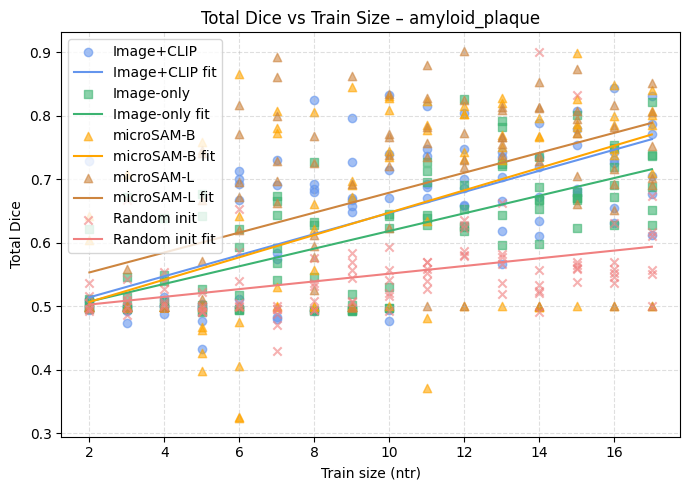

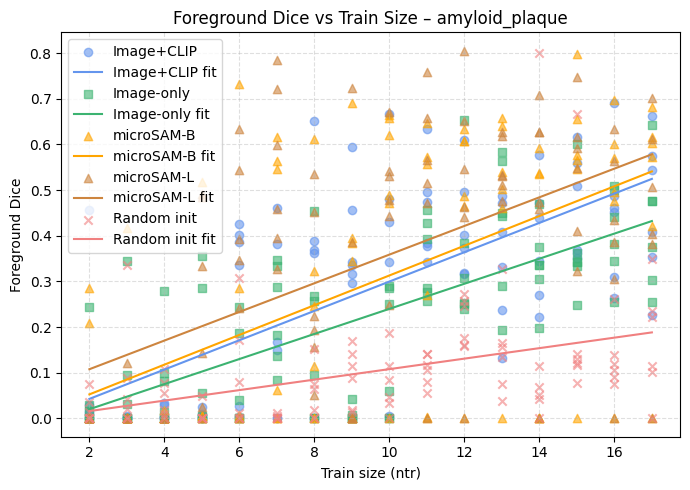

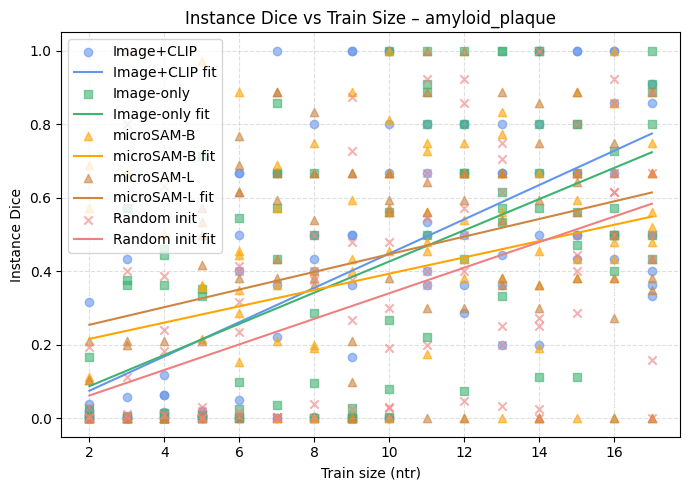

Data type: c_fos_positive


,model,train_size,total_dice,foreground_dice,instance_dice,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
16,Image+CLIP,2,0.7623,0.5367,0.8602,nan,nan,nan,nan,nan,nan
96,Image-only,2,0.7427,0.5008,0.7731,nan,nan,nan,nan,nan,nan
154,microSAM-B,2,0.4952,0.0000,0.0000,nan,nan,nan,nan,nan,nan
230,microSAM-L,2,0.4952,0.0000,0.0000,nan,nan,nan,nan,nan,nan
306,Random init,2,0.6911,0.3992,0.6972,nan,nan,nan,nan,nan,nan


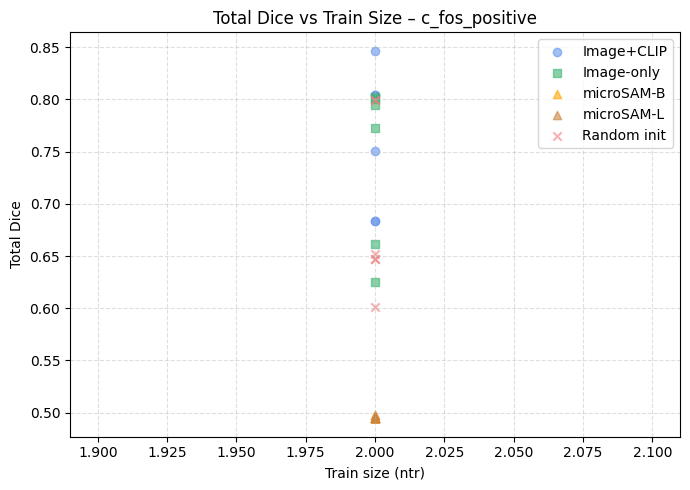

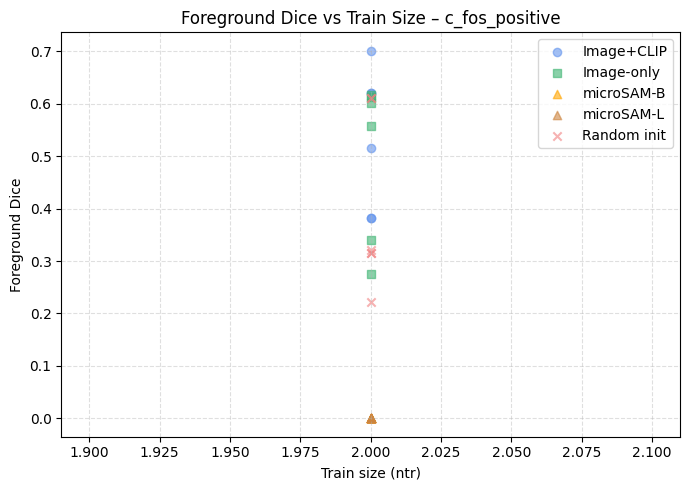

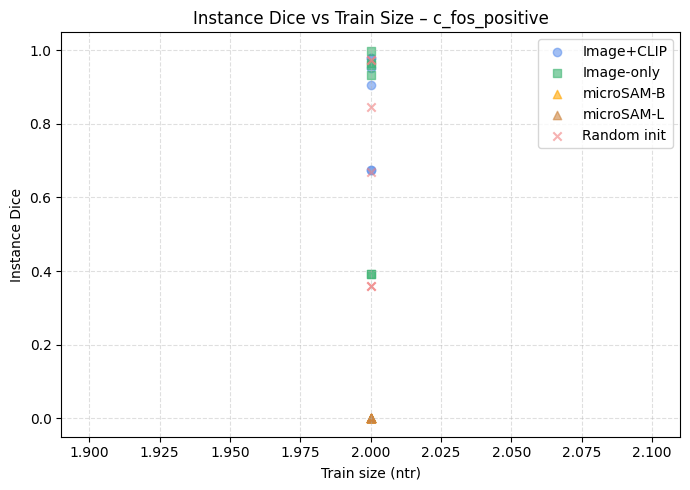

Data type: cell_nucleus


,model,train_size,total_dice,foreground_dice,instance_dice,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
17,Image+CLIP,2,0.7654,0.5460,0.9170,nan,nan,nan,nan,nan,nan
58,CellSeg3D,2,0.5016,0.0199,0.7908,nan,nan,nan,nan,nan,nan
97,Image-only,2,0.7820,0.5796,0.8923,nan,nan,nan,nan,nan,nan
155,microSAM-B,2,0.4935,0.0000,0.0000,nan,nan,nan,nan,nan,nan
231,microSAM-L,2,0.4935,0.0000,0.0000,nan,nan,nan,nan,nan,nan
307,Random init,2,0.7699,0.5561,0.9153,nan,nan,nan,nan,nan,nan
18,Image+CLIP,3,0.7559,0.5291,0.9423,nan,nan,nan,nan,nan,nan
59,CellSeg3D,3,0.5016,0.0199,0.7908,nan,nan,nan,nan,nan,nan
98,Image-only,3,0.7530,0.5240,0.9398,nan,nan,nan,nan,nan,nan
156,microSAM-B,3,0.4935,0.0000,0.0000,nan,nan,nan,nan,nan,nan


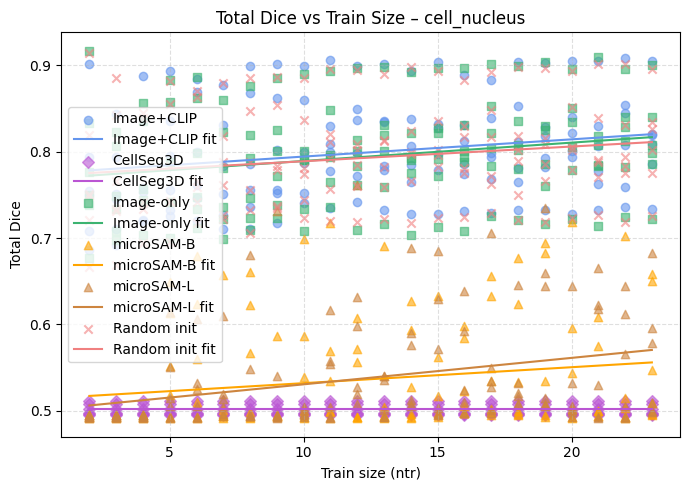

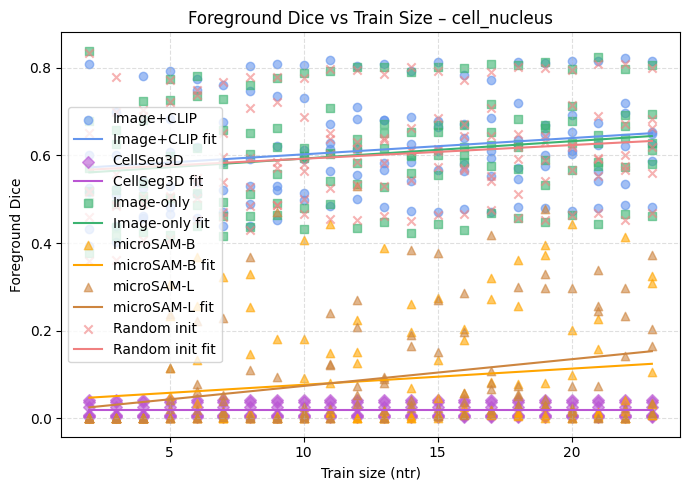

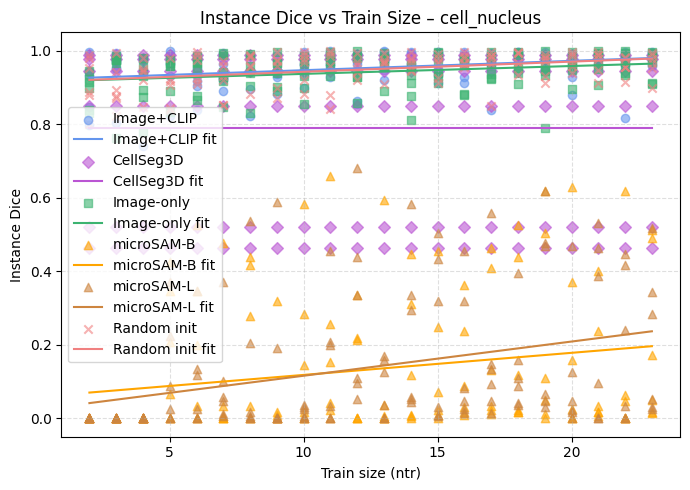

Data type: vessels


,model,train_size,total_dice,foreground_dice,instance_dice,pred_betti_0,pred_betti_1,pred_betti_2,gt_betti_0,gt_betti_1,gt_betti_2
39,Image+CLIP,2,0.8218,0.6795,0.8137,nan,nan,nan,nan,nan,nan
119,Image-only,2,0.8035,0.6452,0.6544,nan,nan,nan,nan,nan,nan
177,microSAM-B,2,0.6093,0.2592,0.4828,nan,nan,nan,nan,nan,nan
253,microSAM-L,2,0.5109,0.0593,0.3887,nan,nan,nan,nan,nan,nan
329,Random init,2,0.8099,0.6570,0.7184,nan,nan,nan,nan,nan,nan
40,Image+CLIP,3,0.8241,0.6830,0.7235,nan,nan,nan,nan,nan,nan
120,Image-only,3,0.8141,0.6659,0.7617,nan,nan,nan,nan,nan,nan
178,microSAM-B,3,0.6657,0.3689,0.7811,nan,nan,nan,nan,nan,nan
254,microSAM-L,3,0.7781,0.5882,0.6513,nan,nan,nan,nan,nan,nan
330,Random init,3,0.8154,0.6715,0.4643,nan,nan,nan,nan,nan,nan


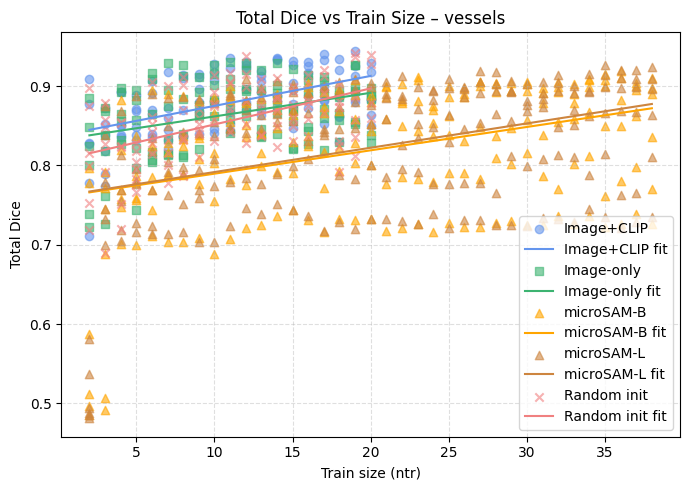

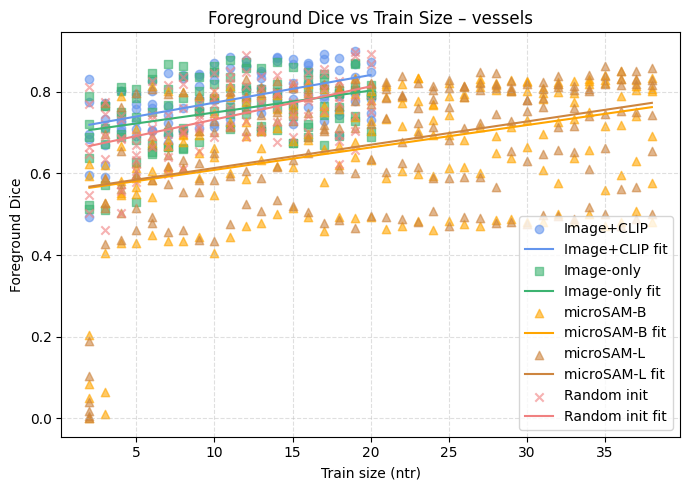

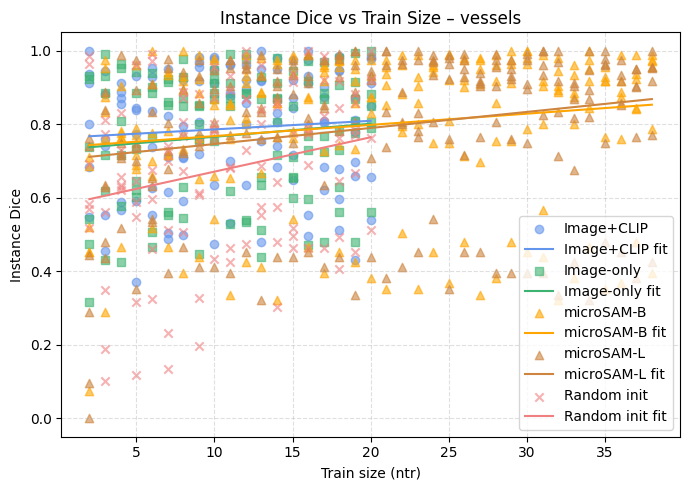

In [3]:
"""
SELMA3D segmentation metrics and plots for multiple models
(including microSAM finetuned cross‑val results).

Metrics per patch:
- total_dice      : average of foreground and background Dice
- foreground_dice : Dice on foreground voxels only (union of pred/GT foreground)
- instances_pred  : # of connected components in prediction
- instances_gt    : # of connected components in GT
- Betti numbers   : b0, b1, b2 (for pred and GT), optional (requires gudhi)

Final summary tables / plots:
- Per‑file metrics table
- Fold‑level and train‑size‑level summaries
- Tables and plots vs train size (ntr)

Models:
- autumn  (pretrained model, prob maps)
- expert  (pretrained model, prob maps)
- random  (random init baseline, prob maps)
- microsam (microSAM finetuned models, instance‑label predictions)
"""

# ==========================
# Imports & Config
# ==========================

import os
from pathlib import Path
import re
import tifffile as tiff
import warnings

import nibabel as nib
import numpy as np
import pandas as pd

from scipy.ndimage import label as cc_label

# Optional: Betti numbers via Gudhi (cubical complex)
# If this import fails, Betti numbers will be disabled unless you
# install gudhi (e.g., `pip install gudhi`).
try:
    import gudhi
    HAS_GUDHI = True
except ImportError:
    HAS_GUDHI = False
    warnings.warn(
        "Gudhi not installed. Betti numbers will be disabled unless you install gudhi."
    )

# -------------------
# PATH CONFIGURATION
# -------------------

# Prediction roots (already point at the .../preds folders)
MODEL_ROOTS = {
    "autumn": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds"),
    "expert": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds"),
    "random": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds"),
    # microSAM finetuned predictions (two variants: b and l)
    "microsam_b": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_b/preds"),
    "microsam_l": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_l/preds"),
    "cellseg3d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellseg3d/finetuned_cross_val/preds"),
}

# Ground‑truth root
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")

# Datatype <-> GT folder mapping
DATA_TYPES = ["amyloid_plaque", "c_fos_positive", "cell_nucleus", "vessels"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

# Define output directory
OUTPUT_DIR = Path("/midtier/paetzollab/scratch/ads4015/segmentation_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Threshold on probability map to get binary prediction
PROB_THRESHOLD = 0.5

# Connectivity structure for 3D connected components (26‑connectivity)
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)

# Whether to compute Betti numbers (requires gudhi)
ENABLE_BETTI = HAS_GUDHI
ENABLE_BETTI = False  # override for now
print(f"Gudhi installed: {HAS_GUDHI}, ENABLE_BETTI = {ENABLE_BETTI}")


# =======================================
# Utility: NIfTI Loader & Filename Parsing
# =======================================

def load_nifti(path: Path) -> np.ndarray:
    """Load a NIfTI file and return a float32 numpy array."""
    img = nib.load(str(path))
    arr = img.get_fdata(dtype=np.float32)
    return arr


# Regex for prediction filename patterns
# Example (pretrained models):
#   patch_003_vol016_ch0_prob_cvfold2_ntr12_nev2_fttr10_ftval2_fold2_trlim12_seed100.nii.gz
PRED_NAME_RE = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_prob_.*\.nii\.gz$")

# Example (microSAM-b preds, old format):
#   patch_005_vol001_ch0.nii_pred_cvfold0_pool3_ntr2_nval1_ntest2_seed100.nii.gz
PRED_NAME_RE_MICROSAM_B = re.compile(
    r"^patch_(\d+)_vol(\d+)_ch(\d+)\.nii_pred_.*\.nii\.gz$"
)

# Example (microSAM-l preds, new format):
#   patch_007_vol005_ch0_pred_cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_seed100.nii.gz
PRED_NAME_RE_MICROSAM_L = re.compile(
    r"^patch_(\d+)_vol(\d+)_ch(\d+)_pred_.*\.nii\.gz$"
)

PRED_STEM_RE_CELLSEG3D = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_instances$")


def parse_pred_name(pred_path: Path, model_name: str):
    """Parse patch_id, vol_id, channel_id from a prediction filename.

    Uses different regexes for microsam_b / microsam_l vs the other models.
    """
    if model_name == "microsam_b":
        m = PRED_NAME_RE_MICROSAM_B.match(pred_path.name)
    elif model_name == "microsam_l":
        m = PRED_NAME_RE_MICROSAM_L.match(pred_path.name)
    elif model_name == "cellseg3d":
        m = PRED_STEM_RE_CELLSEG3D.match(pred_path.stem)
    else:
        m = PRED_NAME_RE.match(pred_path.name)

    if m is None:
        raise ValueError(f"Cannot parse prediction filename for model={model_name}: {pred_path}")

    patch_id, vol_id, ch_id = m.groups()
    return patch_id, vol_id, ch_id


def build_gt_path(data_type: str, patch_id: str, vol_id: str, ch_id: str) -> Path:
    """Build the ground‑truth label path from metadata."""
    gt_subdir = DATA_TYPE_TO_GT_SUBDIR[data_type]
    gt_folder = GT_ROOT / gt_subdir
    gt_name = f"patch_{patch_id}_vol{vol_id}_ch{ch_id}_label.nii.gz"
    return gt_folder / gt_name


# ======================================
# Dice Metrics (Total & Foreground)
# ======================================

def binary_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Standard foreground Dice on full volume."""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection + eps) / (pred.sum() + gt.sum() + eps)


def background_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Dice between background regions."""
    pred_bg = np.logical_not(pred)
    gt_bg = np.logical_not(gt)
    intersection = np.logical_and(pred_bg, gt_bg).sum()
    return (2.0 * intersection + eps) / (pred_bg.sum() + gt_bg.sum() + eps)


def total_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """'Total Dice' = average of foreground and background Dice scores."""
    fg_d = binary_dice(pred_bin, gt_bin, eps=eps)
    bg_d = background_dice(pred_bin, gt_bin, eps=eps)
    return 0.5 * (fg_d + bg_d)


def foreground_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """Foreground Dice computed only on voxels that are foreground in either pred or GT.

    This uses the union of pred/GT foreground voxels as the evaluation region.
    If the union is empty (both masks all‑background), returns 1.0 by convention.
    """
    pred_bin = pred_bin.astype(bool)
    gt_bin = gt_bin.astype(bool)
    fg_union = np.logical_or(pred_bin, gt_bin)
    if fg_union.sum() == 0:
        return 1.0

    pred_f = pred_bin[fg_union]
    gt_f = gt_bin[fg_union]
    intersection = np.logical_and(pred_f, gt_f).sum()
    return (2.0 * intersection + eps) / (pred_f.sum() + gt_f.sum() + eps)


# ========================================
# Instance Counts (Connected Components)
# ========================================

def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    """Count connected components (instances) in a 3D binary mask."""
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    labeled, n_components = cc_label(mask, structure=structure)
    return int(n_components)


# ================================
# Betti Numbers (Optional)
# ================================

def compute_betti(mask: np.ndarray):
    """Compute Betti numbers (b0, b1, b2) of a 3D binary mask via Gudhi.

    Returns a dict with keys 'betti_0', 'betti_1', 'betti_2'.
    If ENABLE_BETTI is False, returns NaNs for these values.
    """
    if not ENABLE_BETTI:
        return {"betti_0": np.nan, "betti_1": np.nan, "betti_2": np.nan}

    data = mask.astype(np.float32)
    cc = gudhi.CubicalComplex(dimensions=data.shape, top_dimensional_cells=data.flatten())
    bettis = cc.betti_numbers()  # list [b0, b1, b2, ...]

    b = [0, 0, 0]
    for i in range(min(len(bettis), 3)):
        b[i] = bettis[i]

    return {"betti_0": b[0], "betti_1": b[1], "betti_2": b[2]}


# =========================================
# Per‑patch Metric Computation
# =========================================

def compute_metrics_for_pair(pred_path: Path, gt_path: Path) -> dict:
    """Compute all metrics for a single prediction/GT pair.

    Returns a flat dict of metric_name -> value.
    """
    if pred_path.suffix == ".tif":
        pred_prob = tiff.imread(str(pred_path)).astype(np.float32)
    else:
        pred_prob = load_nifti(pred_path)
    gt_bin = load_nifti(gt_path)

    # Binarize
    # For pretrained models, pred_prob is a probability map.
    # For microSAM, pred_prob is an instance‑label map; thresholding at 0.5
    # turns all nonzero labels into foreground.
    pred_bin = pred_prob >= PROB_THRESHOLD
    gt_bin = gt_bin > 0.5  # GT should already be 0/1, but this is safe

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(
            f"Shape mismatch: pred {pred_bin.shape}, gt {gt_bin.shape} for {pred_path} vs {gt_path}"
        )

    # Dice metrics
    td = total_dice(pred_bin, gt_bin)
    fd = foreground_dice(pred_bin, gt_bin)

    # Instance counts
    n_inst_pred = count_instances(pred_bin)
    n_inst_gt = count_instances(gt_bin)

    # Instance Dice based on counts (scalar Dice on instance numbers)
    if n_inst_pred == 0 and n_inst_gt == 0:
        inst_dice = 1.0
    else:
        inst_dice = (2.0 * min(n_inst_pred, n_inst_gt)) / float(n_inst_pred + n_inst_gt)

    # Betti numbers (for predictions and GT separately)
    betti_pred = compute_betti(pred_bin)
    betti_gt = compute_betti(gt_bin)

    metrics = {
        "total_dice": td,
        "foreground_dice": fd,
        "instance_dice": inst_dice,
        "instances_pred": n_inst_pred,
        "instances_gt": n_inst_gt,
    }

    # Prefix Betti keys
    for k, v in betti_pred.items():
        metrics[f"pred_{k}"] = v
    for k, v in betti_gt.items():
        metrics[f"gt_{k}"] = v

    return metrics


# ==================================================
# Discovery & Loop Over All Models / Types
# ==================================================

def discover_pred_files(model_name: str, model_root: Path, data_type: str):
    """Discover all prediction files for a given model root and data_type.

    Returns a list of (pred_path, cvfold_name).
    """

    # === Special case: CellSeg3D only has predictions for cell_nucleus ===
    if model_name == "cellseg3d" and data_type != "cell_nucleus":
        return []

    results = []

    # ----------------------------
    # microSAM directory structure(s)
    # ----------------------------
    if model_name.startswith("microsam"):
        # For microSAM, data_type is the short name (e.g. "amyloid_plaque"),
        # and DATA_TYPE_TO_GT_SUBDIR gives the full folder (e.g. "amyloid_plaque_patches").
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type]
        if not type_root.is_dir():
            warnings.warn(f"{type_root} does not exist for {model_name}; skipping.")
            return results

        # microsam_b: old format, e.g. fold_cv0_pool3_ntr2_nval1_ntest2/patches
        # microsam_l: new format, e.g. cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_seed100/patches
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue

            if model_name == "microsam_b":
                if not fold_dir.name.startswith("fold_cv"):
                    continue
            elif model_name == "microsam_l":
                if not fold_dir.name.startswith("cvfold"):
                    continue

            cvfold_name = fold_dir.name
            preds_dir = fold_dir / "patches"
            if not preds_dir.is_dir():
                warnings.warn(f"No patches/ directory in {fold_dir}; skipping.")
                continue

            for pred_path in sorted(preds_dir.glob("patch_*.nii.gz")):
                results.append((pred_path, cvfold_name))

        return results
    
    # ----------------------------
    # CellSeg3D TIFF predictions
    # ----------------------------
    if model_name == "cellseg3d":
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type] # CellSeg3D uses the same folder naming as GT root (e.g., cell_nucleus_patches)
        if not type_root.is_dir():
            warnings.warn(f"{type_root} missing for CellSeg3D; skipping.")
            return []

        results = []
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue
            if not fold_dir.name.startswith("cvfold"):
                continue
            cvfold_name = fold_dir.name
            preds_dir = fold_dir

            # Use instances outputs only
            for pred_path in sorted(preds_dir.glob("*_instances.tif")):
                results.append((pred_path, cvfold_name))

        return results


    # -------------------------------------------
    # Original structure for autumn/expert/random
    # -------------------------------------------
    type_root = model_root / data_type
    if not type_root.is_dir():
        warnings.warn(f"{type_root} does not exist; skipping.")
        return results

    # cvfold directories like: cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100
    for fold_dir in sorted(type_root.iterdir()):
        if not fold_dir.is_dir():
            continue
        if not fold_dir.name.startswith("cvfold"):
            continue

        cvfold_name = fold_dir.name  # keep full string
        preds_dir = fold_dir / "preds"
        if not preds_dir.is_dir():
            warnings.warn(f"No preds/ directory in {fold_dir}; skipping.")
            continue

        for pred_path in sorted(preds_dir.glob("*_prob_*.nii.gz")):
            # Only use raw probability maps; skip thresholded *_pred_* files
            results.append((pred_path, cvfold_name))

    return results


def collect_all_metrics():
    """Iterate over models, data types, CV folds, and compute per‑file metrics.
    Returns a pandas DataFrame with one row per prediction file.
    """
    rows = []

    for model_name, model_root in MODEL_ROOTS.items():
        print(f"\n[INFO] Processing model: {model_name} ({model_root})")

        for data_type in DATA_TYPES:
            print(f"  - data_type: {data_type}")
            pred_items = discover_pred_files(model_name, model_root, data_type)

            for pred_path, cvfold_name in pred_items:
                try:
                    patch_id, vol_id, ch_id = parse_pred_name(pred_path, model_name)
                except ValueError as e:
                    warnings.warn(str(e))
                    continue

                gt_path = build_gt_path(data_type, patch_id, vol_id, ch_id)

                if not gt_path.is_file():
                    warnings.warn(f"GT not found for {pred_path}: {gt_path}")
                    continue

                try:
                    metrics = compute_metrics_for_pair(pred_path, gt_path)
                except Exception as e:
                    warnings.warn(f"Failed metrics for {pred_path} vs {gt_path}: {e}")
                    continue

                # cvfold_id is a coarse identifier (e.g. 'cvfold0' or 'fold_cv0')
                parts = cvfold_name.split("_")
                if len(parts) >= 2 and parts[0] == "fold" and parts[1].startswith("cv"):
                    cvfold_id = "_".join(parts[:2])  # e.g. 'fold_cv0'
                else:
                    cvfold_id = parts[0]               # e.g. 'cvfold0'

                row = {
                    "model": model_name,
                    "data_type": data_type,
                    "cvfold": cvfold_name,   # full string
                    "cvfold_id": cvfold_id,
                    "patch_id": patch_id,
                    "vol_id": vol_id,
                    "channel_id": ch_id,
                    "pred_path": str(pred_path),
                    "gt_path": str(gt_path),
                }
                row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    return df


# =======================================
# Run collection to get per‑file metrics
# =======================================

metrics_df = collect_all_metrics()
print("\n[INFO] Done. Number of rows:", len(metrics_df))
try:
    display(metrics_df.head())  # works in notebooks
except NameError:
    print(metrics_df.head())


# =======================================
# Extract train size from cvfold name
# =======================================


def extract_train_size_from_row(row):
    """Extract the x-axis 'train_size' from a row.

    For autumn/expert/random and microsam_l:
        use `_ntr<k>_` from cvfold name.

    For microsam_b (old format):
        use `_pool<p>_` from cvfold name.
    """
    cvfold_name = row["cvfold"]
    model_name = row["model"]

    if model_name == "microsam_b":
        m_pool = re.search(r"_pool(\d+)_", cvfold_name)
        if m_pool:
            return int(m_pool.group(1))
        # fallback to ntr if pool not found
        m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
        if m_ntr:
            return int(m_ntr.group(1))
        return np.nan

    # autumn / expert / random / microsam_l: standard ntr
    m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
    if m_ntr:
        return int(m_ntr.group(1))
    return np.nan


metrics_df["train_size"] = metrics_df.apply(extract_train_size_from_row, axis=1)

print("[INFO] Unique train sizes found:", sorted(metrics_df["train_size"].dropna().unique()))
try:
    display(metrics_df.head())
except NameError:
    print(metrics_df.head())


# ==========================================================
# Fold-level summary (per train size / cvfold)
# ==========================================================

# Metrics to aggregate
metric_columns = [
    "total_dice",
    "foreground_dice",
    "instance_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

# We average over files *within* a cvfold directory (e.g., 2 outputs per fold),
# but keep each cvfold/train_size separate.
summary_by_model_type_fold = (
    metrics_df
    .groupby(["model", "data_type", "cvfold", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size", "cvfold"])
)

print("[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):")
try:
    display(summary_by_model_type_fold.head())
except NameError:
    print(summary_by_model_type_fold.head())

summary_fold_csv_path = OUTPUT_DIR / "summary_by_model_type_and_fold_train_size.csv"
summary_by_model_type_fold.to_csv(summary_fold_csv_path, index=False)
print("Fold-level summary saved to:", summary_fold_csv_path)


# ==========================================================
# Train-size summary (averaged over folds)
# ==========================================================

# For each (model, data_type, train_size), average metrics over all
# folds that share the same train_size. This is what we will use for
# the tables and plots.
summary_by_model_type_train = (
    summary_by_model_type_fold
    .groupby(["model", "data_type", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size"])
)

train_summary_csv_path = OUTPUT_DIR / "summary_by_model_type_and_train_size.csv"
summary_by_model_type_train.to_csv(train_summary_csv_path, index=False)
print("Train-size-averaged summary saved to:", train_summary_csv_path)


# ======================================
# Save Raw Metrics to CSV
# ======================================

raw_csv_path = OUTPUT_DIR / "selma3d_segmentation_metrics_per_file.csv"
metrics_df.to_csv(raw_csv_path, index=False)
print("Raw per-file metrics saved to:", raw_csv_path)


# ==========================================================
# Summary: Averages over files (all CV folds)
# ==========================================================

metric_columns = [
    "total_dice",
    "foreground_dice",
    "instances_pred",
    "instances_gt",
]

# Add Betti columns if present (may be NaN if ENABLE_BETTI=False)
for col in [
    "pred_betti_0",
    "pred_betti_1",
    "pred_betti_2",
    "gt_betti_0",
    "gt_betti_1",
    "gt_betti_2",
]:
    if col in metrics_df.columns:
        metric_columns.append(col)

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

summary_by_model_type = (
    metrics_df
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

print("\n[INFO] Summary: Averages of each score over all files")
try:
    display(summary_by_model_type)
except NameError:
    print(summary_by_model_type)

summary_csv_path = OUTPUT_DIR / "summary_by_model_and_type_means.csv"
summary_by_model_type.to_csv(summary_csv_path, index=False)
print("Summary (by model & type) saved to:", summary_csv_path)


# ==========================================================
# Optional: two-stage summary with fold-level means
# ==========================================================

fold_means = (
    metrics_df
    .groupby(["model", "data_type", "cvfold_id"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage = (
    fold_means
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage_csv = OUTPUT_DIR / "summary_by_model_and_type_two_stage_means.csv"
summary_two_stage.to_csv(summary_two_stage_csv, index=False)
print("Two-stage fold-then-model means saved to:", summary_two_stage_csv)


# ================================
# Tables & Plots vs Train Size
# ================================

import matplotlib.pyplot as plt

# Choose which metrics to visualize in plots
PLOT_METRICS = ["total_dice", "foreground_dice", "instance_dice"]

# Pretty names, colors, and markers for each model in tables/plots
MODEL_DISPLAY = {
    "autumn": "Image+CLIP",
    "expert": "Image-only",
    "random": "Random init",
    "microsam_b": "microSAM-B",
    "microsam_l": "microSAM-L",
    "cellseg3d": "CellSeg3D",
}

MODEL_COLOR = {
    "autumn": "cornflowerblue",   # Image+CLIP
    "expert": "mediumseagreen",   # Image-only
    "random": "lightcoral",       # Random init
    "microsam_b": "orange",       # microSAM-B
    "microsam_l": "peru",         # microSAM-L (L model)
    "cellseg3d": "mediumorchid",        # CellSeg3D
}

MODEL_MARKER = {
    "autumn": "o",   # dots
    "expert": "s",   # squares
    "random": "x",   # x's
    "microsam_b": "^", # triangles
    "microsam_l": "^", # triangles
    "cellseg3d": "D", # diamonds
}


# 1) Pretty table view for each data_type

def show_summary_table_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Sort rows by train size then model so it's easy to read
    df_dt = df_dt.sort_values(["train_size", "model"])

    # Use pretty display names for the model column in the table
    df_dt["model"] = df_dt["model"].map(lambda m: MODEL_DISPLAY.get(m, m))

    # Betti columns (if present)
    betti_cols = [
        c
        for c in [
            "pred_betti_0",
            "pred_betti_1",
            "pred_betti_2",
            "gt_betti_0",
            "gt_betti_1",
            "gt_betti_2",
        ]
        if c in df_dt.columns
    ]

    cols = ["model", "train_size"] + PLOT_METRICS + betti_cols
    cols = [c for c in cols if c in df_dt.columns]

    table = df_dt[cols]

    num_format_cols = [c for c in PLOT_METRICS + betti_cols if c in table.columns]

    try:
        styled = (
            table.style
            .format("{:.4f}", subset=num_format_cols)
            .set_caption(f"Train-size-averaged summary for data type: {data_type}")
            .background_gradient(axis=None)
        )
        display(styled)
    except NameError:
        print(table)


# 2) Line plots: metric vs train_size, one line per model

def plot_metric_vs_train_size_for_type(data_type: str):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Ensure sorted order of train sizes
    df_dt = df_dt.sort_values(["train_size", "model"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in summary table; skipping.")
            continue

        plt.figure(figsize=(6, 4))

        for model, df_m in df_dt.groupby("model"):
            display_name = MODEL_DISPLAY.get(model, model)
            color = MODEL_COLOR.get(model, None)
            marker = MODEL_MARKER.get(model, "o")

            plt.plot(
                df_m["train_size"],
                df_m[metric],
                marker=marker,
                label=display_name,
                color=color,
            )

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}")
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()


# 3) Scatter + regression lines using file-level metrics


def plot_scatter_and_regression_for_type(data_type: str):
    # Use per-file metrics (metrics_df), not the fold-averaged summary
    df_dt = metrics_df[metrics_df["data_type"] == data_type].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Drop rows where train_size is missing
    df_dt = df_dt.dropna(subset=["train_size"])

    # Sort mainly for nicer lines
    df_dt = df_dt.sort_values(["train_size", "model", "cvfold", "patch_id"])

    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            print(f"[WARN] Metric '{metric}' not in metrics_df; skipping.")
            continue

        df_metric = df_dt.dropna(subset=[metric])
        if df_metric.empty:
            print(f"[WARN] No non-NaN values for metric '{metric}' in {data_type}; skipping.")
            continue

        plt.figure(figsize=(7, 5))

        # Plot all file-level points per model
        for model, df_m in df_metric.groupby("model"):
            display_name = MODEL_DISPLAY.get(model, model)
            color = MODEL_COLOR.get(model, None)
            marker = MODEL_MARKER.get(model, "o")

            plt.scatter(
                df_m["train_size"],
                df_m[metric],
                label=f"{display_name}",
                alpha=0.6,
                color=color,
                marker=marker,
            )

            # Fit a best-fit line across all file-level points
            x = df_m["train_size"].astype(float).to_numpy()
            y = df_m[metric].astype(float).to_numpy()
            # need at least 2 distinct train_sizes for a line
            if len(np.unique(x)) > 1:
                coef = np.polyfit(x, y, 1)  # linear fit
                poly = np.poly1d(coef)
                xs = np.linspace(min(x), max(x), 100)
                plt.plot(
                    xs,
                    poly(xs),
                    label=f"{display_name} fit",
                    color=color,
                    linestyle="-",
                )

        plt.xlabel("Train size (ntr)")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(
            f"{metric.replace('_', ' ').title()} vs Train Size – {data_type}"
        )
        plt.grid(axis="both", linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


# ================================
# Run tables + scatter/lines per datatype (in notebook)
# ================================

for dt in DATA_TYPES:
    print("==============================")
    print(f"Data type: {dt}")
    print("==============================")
    show_summary_table_for_type(dt)
    plot_scatter_and_regression_for_type(dt)
